In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r"D:\BA NOTES Specialization\Python\Binary Classification with a Bank Churn Dataset\sample_submission.csv\train.csv")
test = pd.read_csv(r"D:\BA NOTES Specialization\Python\Binary Classification with a Bank Churn Dataset\sample_submission.csv\test.csv")


In [3]:
trainsize = train.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"train dataset memory usage: {trainsize:,.2f} MB")
train

train dataset memory usage: 43.50 MB


id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0    15674932  Okwudilichukwu          668    France    Male   
1            1    15749177   Okwudiliolisa          627    France    Male   
2            2    15694510           Hsueh          678    France    Male   
3            3    15741417             Kao          581    France    Male   
4            4    15766172       Chiemenam          716     Spain    Male   
...        ...         ...             ...          ...       ...     ...   
165029  165029    15667085            Meng          667     Spain  Female   
165030  165030    15665521       Okechukwu          792    France    Male   
165031  165031    15664752            Hsia          565    France    Male   
165032  165032    15689614          Hsiung          554     Spain  Female   
165033  165033    15732798         Ulyanov          850    France    Male   

         Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       33.0       3       0.00              2        1.0             0.0   
1       33.0       1       0.00              2        1.0             1.0   
2       40.0      10       0.00              2        1.0             0.0   
3       34.0       2  148882.54              1        1.0             1.0   
4       33.0       5       0.00              2        1.0             1.0   
...      ...     ...        ...            ...        ...             ...   
165029  33.0       2       0.00              1        1.0             1.0   
165030  35.0       3       0.00              1        0.0             0.0   
165031  31.0       5       0.00              1        1.0             1.0   
165032  30.0       7  161533.00              1        0.0             1.0   
165033  31.0       1       0.00              1        1.0             0.0   

        EstimatedSalary  Exited  
0             181449.97       0  
1              49503.50       0  
2             184866.69       0  
3              84560.88       0  
4              15068.83       0  
...                 ...     ...  
165029        131834.75       0  
165030        131834.45       0  
165031        127429.56       0  
165032         71173.03       0  
165033         61581.79       1  

[165034 rows x 14 columns]

In [4]:
testsize = test.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"test dataset memory usage: {testsize:,.2f} MB")
test

test dataset memory usage: 28.16 MB


id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
0       165034    15773898   Lucchese          586    France  Female  23.0   
1       165035    15782418       Nott          683    France  Female  46.0   
2       165036    15807120         K?          656    France  Female  34.0   
3       165037    15808905  O'Donnell          681    France    Male  36.0   
4       165038    15607314    Higgins          752   Germany    Male  38.0   
...        ...         ...        ...          ...       ...     ...   ...   
110018  275052    15662091      P'eng          570     Spain    Male  29.0   
110019  275053    15774133        Cox          575    France  Female  36.0   
110020  275054    15728456      Ch'iu          712    France    Male  31.0   
110021  275055    15687541   Yegorova          709    France  Female  32.0   
110022  275056    15663942       Tuan          621    France  Female  37.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0            2       0.00              2        0.0             1.0   
1            2       0.00              1        1.0             0.0   
2            7       0.00              2        1.0             0.0   
3            8       0.00              1        1.0             0.0   
4           10  121263.62              1        1.0             0.0   
...        ...        ...            ...        ...             ...   
110018       7  116099.82              1        1.0             1.0   
110019       4  178032.53              1        1.0             1.0   
110020       2       0.00              2        1.0             0.0   
110021       3       0.00              1        1.0             1.0   
110022       7   87848.39              1        1.0             0.0   

        EstimatedSalary  
0             160976.75  
1              72549.27  
2             138882.09  
3             113931.57  
4             139431.00  
...                 ...  
110018        148087.62  
110019         42181.68  
110020         16287.38  
110021        158816.58  
110022         24210.56  

[110023 rows x 13 columns]

# Key Observations About Initial Dataset Impressions
With a large number of samples to learn from, our results may be more stable between local CV, public LB, and private LB.
There are 11 different features to learn from:
From a rough overview, they appear to be a mixture of continuous features (CreditScore, Balance), categorical (Tenure, Surname, Geography), and boolean (HasCrCard, IsActiveMember). We will need to dig deeper to ensure this is indeed the case.

# Null Values

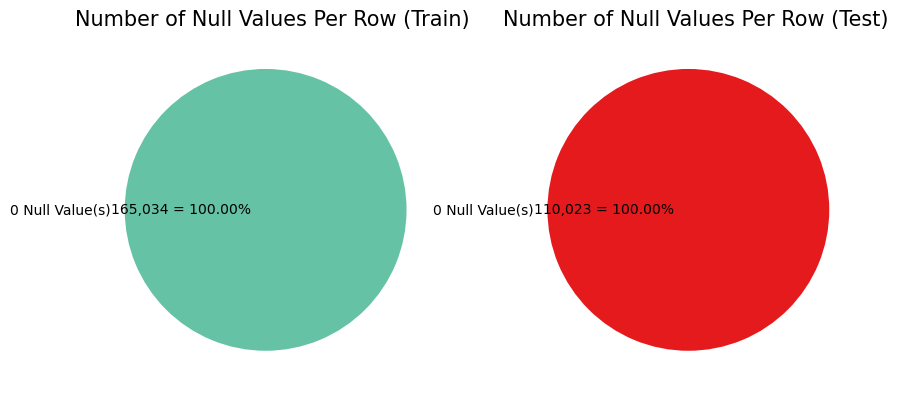

In [5]:
train["null_count"] = train.isnull().sum(axis=1)
counts = train.groupby("null_count")["id"].count().to_dict()
null_data = {"{} Null Value(s)".format(k) : v for k, v in counts.items() if k < 8}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

axs = axs.flatten()

_ = axs[0].pie(
    x=list(null_data.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_data.values())/100, x),
    explode=[0.05] * len(null_data.keys()), 
    labels=null_data.keys(), 
    colors=sns.color_palette("Set2")[0:3],
)
_ = axs[0].set_title("Number of Null Values Per Row (Train)", fontsize=15)

test["null_count"] = test.isnull().sum(axis=1)
counts = test.groupby("null_count")["id"].count().to_dict()
null_data = {"{} Null Value(s)".format(k) : v for k, v in counts.items() if k < 8}

_ = axs[1].pie(
    x=list(null_data.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_data.values())/100, x),
    explode=[0.05] * len(null_data.keys()), 
    labels=null_data.keys(), 
    colors=sns.color_palette("Set1")[0:3],
)
_ = axs[1].set_title("Number of Null Values Per Row (Test)", fontsize=15)

train = train.drop("null_count", axis=1)
test = test.drop("null_count", axis=1)


No null values appear in the training or testing datasets.

# Train / Test Difference - Adversarial Validation

-------> Fold 1 <--------
: AUC ROC = 0.5000886586980334
-------> Fold 2 <--------
: AUC ROC = 0.5039547526978441
-------> Fold 3 <--------
: AUC ROC = 0.5053569088329826
-------> Fold 4 <--------
: AUC ROC = 0.5019344510896273
-------> Fold 5 <--------
: AUC ROC = 0.505864347020105
--> Overall results for out of fold predictions
: AUC ROC = 0.5036889475424524


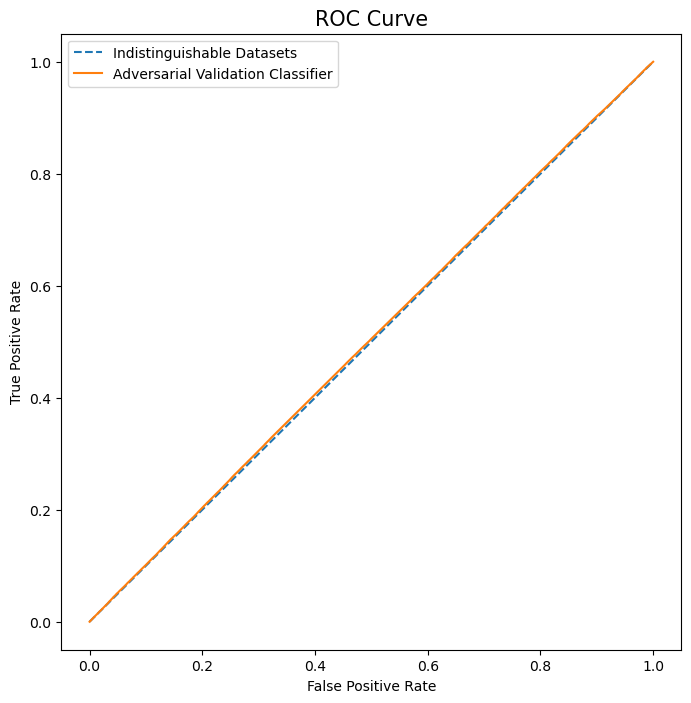

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

train["origin"] = 0
test["origin"] = 1

combined = train.copy()
combined = pd.concat([combined, test]).reset_index(drop=True)

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    combined[feature] = le.fit_transform(combined[feature])
    
n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2024, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=ax)
_ = sns.lineplot(x=fpr[::10], y=tpr[::10], ax=ax, label="Adversarial Validation Classifier")
_ = ax.set_title("ROC Curve", fontsize=15)
_ = ax.set_xlabel("False Positive Rate")
_ = ax.set_ylabel("True Positive Rate")

# Key Observations About Train / Test Difference - Adversarial Validation
The trained classifier has an AUC ROC score of 0.504, which suggests that the training dataset and the testing dataset are very similar.

# Original Data - Adversarial Validation

-------> Fold 1 <--------
: AUC ROC = 0.7723017346554033
-------> Fold 2 <--------
: AUC ROC = 0.7834986901636817
-------> Fold 3 <--------
: AUC ROC = 0.7813826769022196
-------> Fold 4 <--------
: AUC ROC = 0.7712564676106005
-------> Fold 5 <--------
: AUC ROC = 0.7802634678490892
--> Overall results for out of fold predictions
: AUC ROC = 0.7776849357148788


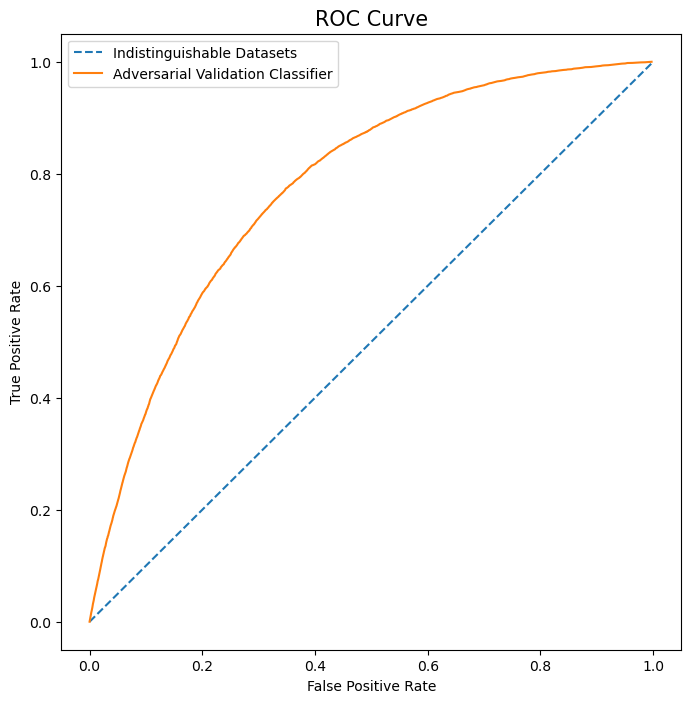

In [7]:
original = pd.read_csv(r"D:\BA NOTES Specialization\Python\Binary Classification with a Bank Churn Dataset\Churn_Modelling.csv")

train["origin"] = 0
test["origin"] = 0
original["origin"] = 1

combined = train.copy()
combined = pd.concat([combined, test]).reset_index(drop=True)
combined = pd.concat([combined, original]).reset_index(drop=True)

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    combined[feature] = le.fit_transform(combined[feature])

n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2024, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=ax)
_ = sns.lineplot(x=fpr[::10], y=tpr[::10], ax=ax, label="Adversarial Validation Classifier")
_ = ax.set_title("ROC Curve", fontsize=15)
_ = ax.set_xlabel("False Positive Rate")
_ = ax.set_ylabel("True Positive Rate")

The AUC ROC score of 0.778 suggests that the original dataset is quite different from the generated one. There may be a number of different reasons, but one obvious one may be due to the names that are used in both datasets. If we remove the names, we can check to see if the remaining data is similar or not.



-------> Fold 1 <--------
: AUC ROC = 0.7097788674883102
-------> Fold 2 <--------
: AUC ROC = 0.7064103895552291
-------> Fold 3 <--------
: AUC ROC = 0.7083661505363226
-------> Fold 4 <--------
: AUC ROC = 0.6975859819983858
-------> Fold 5 <--------
: AUC ROC = 0.7092976976947284
--> Overall results for out of fold predictions
: AUC ROC = 0.7062945851080351


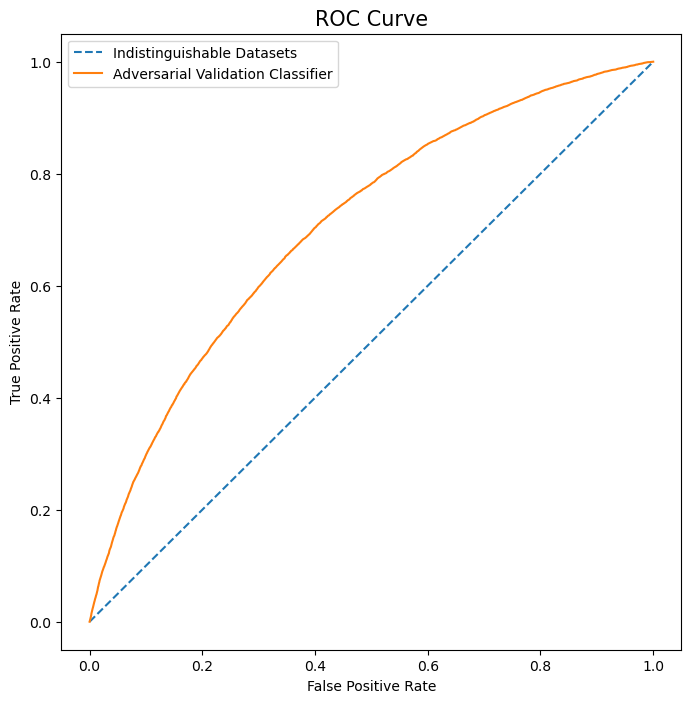

In [8]:
train["origin"] = 0
test["origin"] = 0
original["origin"] = 1

combined = train.copy()
combined = pd.concat([combined, test]).reset_index(drop=True)
combined = pd.concat([combined, original]).reset_index(drop=True)

features = [
    'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    combined[feature] = le.fit_transform(combined[feature])

n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2024, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=ax)
_ = sns.lineplot(x=fpr[::10], y=tpr[::10], ax=ax, label="Adversarial Validation Classifier")
_ = ax.set_title("ROC Curve", fontsize=15)
_ = ax.set_xlabel("False Positive Rate")
_ = ax.set_ylabel("True Positive Rate")

Slightly more similar, but still very distinct. Our categorical columns may still be contributing to easy to spot differences. Or, there may be other columns that are contributing to a very easy to spot difference between the original and the synthetic. We should dig in deeper to see if there are very obvious columns that contribute to similarity. If we can rule out easy-to-spot distinctions, we may be able to use the original dataset as a source of training data.

# Key Observations About Original Data - Adversarial Validation
The classifier has an AUC ROC score of 0.778 - this is quite high, which suggests there are some easy-to-spot differences between the datasets.
Caution should be used when mixing data.
The Surname categorical column appears to be a distinguishing factor between datasets.
We should look to see if there are other big differences between datasets, so we can potentially use the original data to our advantage. 

# Spearman Correlation

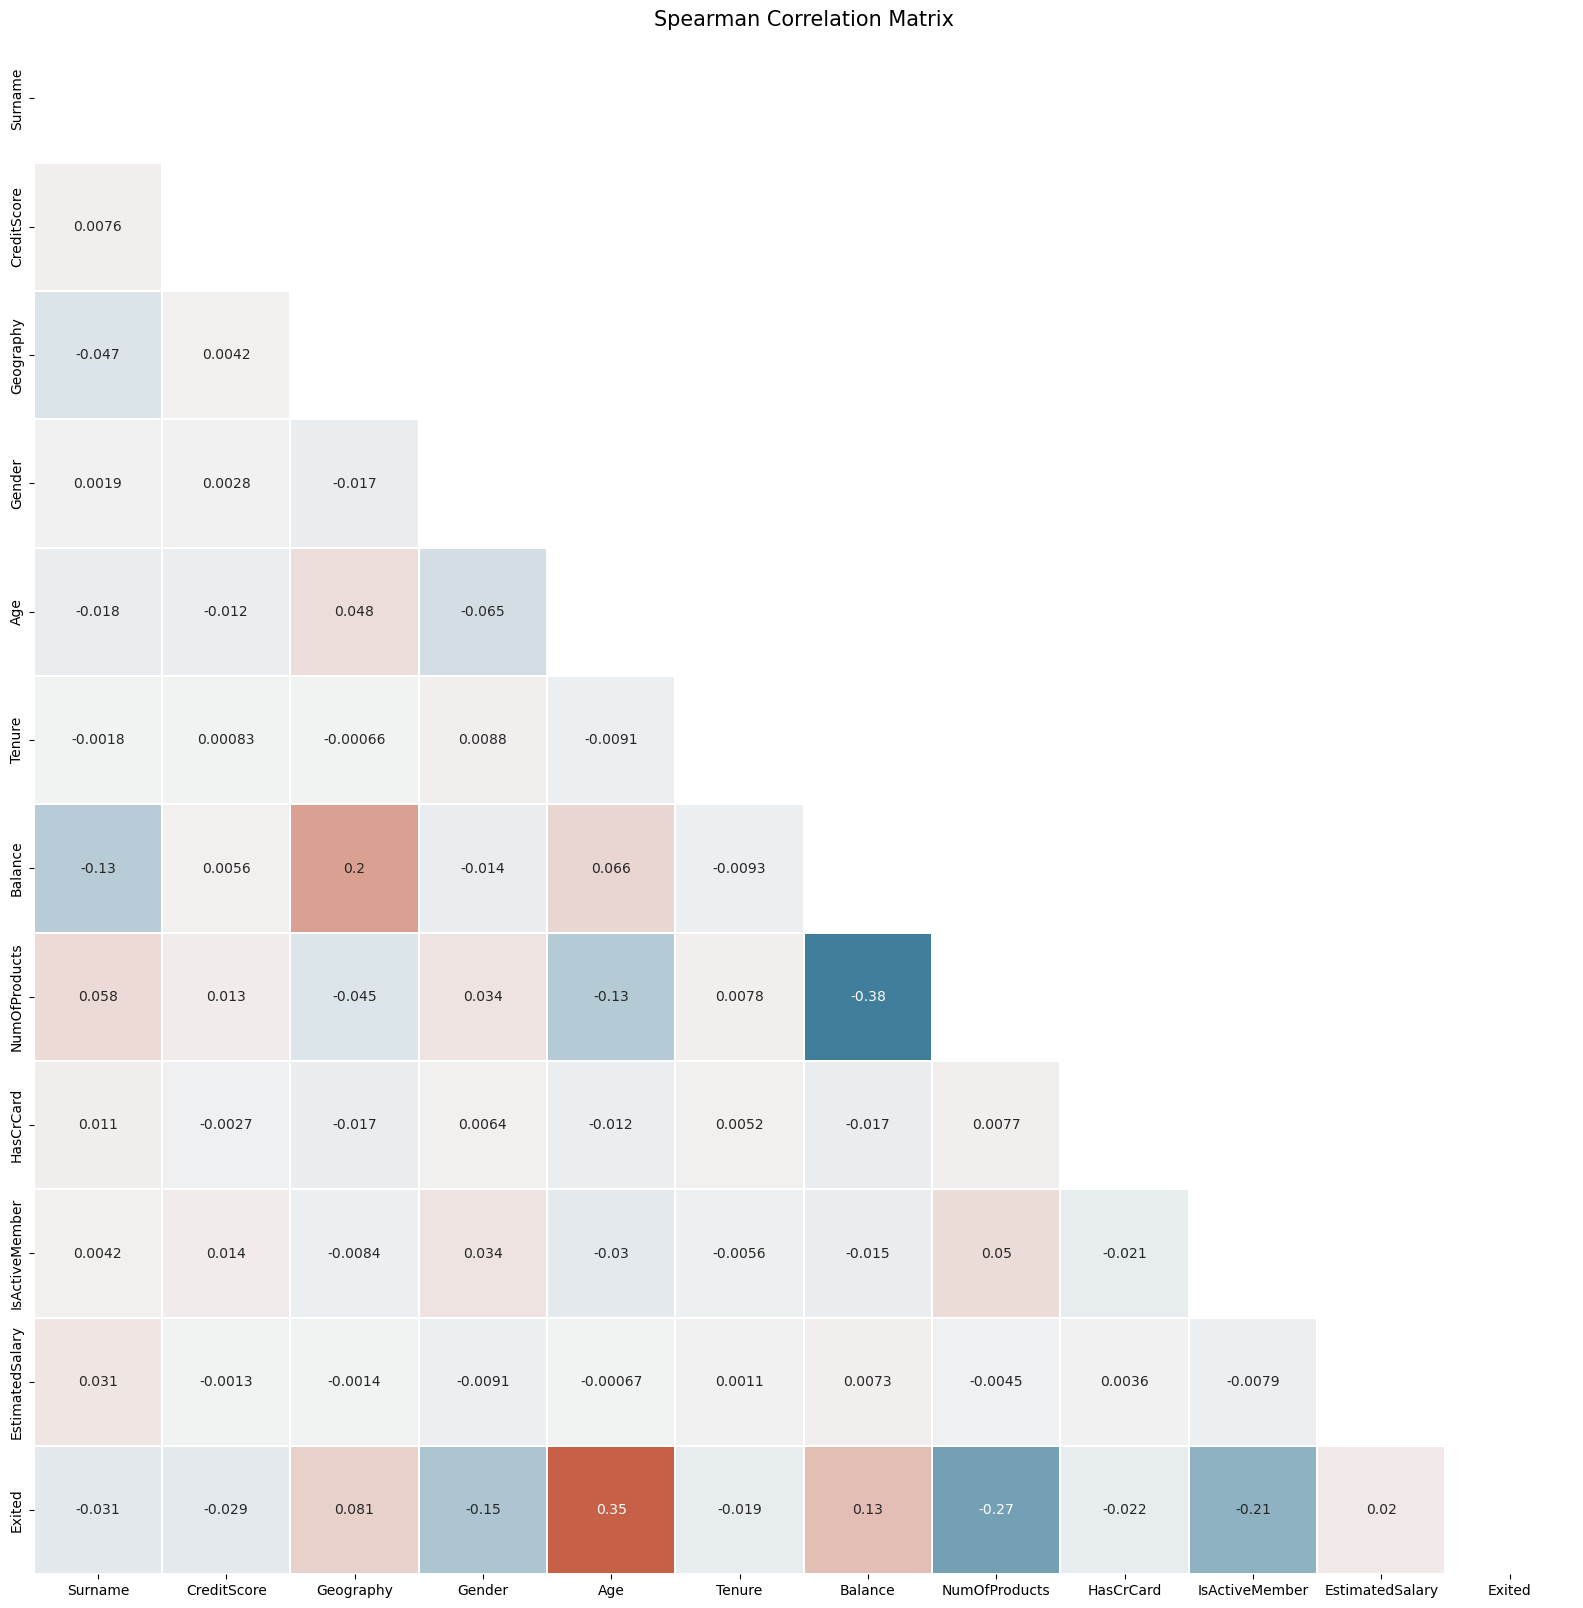

In [9]:
train_copy = train.copy()

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary', 'Exited'
]

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])

correlation_matrix = train_copy[features].corr(method="spearman")

from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=15)

# Key Observations about Spearman Correlation
A strong negative correlation exists between the NumOfProducts and Balance. This is interesting, since it suggests that high balances are not tied to large number of products.
A weakly negative correlation exists between Age and NumOfProucts.
A strong positive correlation exists between Geography and Balance, suggesting there may be areas of the world that have higher balances.
A negative correlation exists between Surname and Balance.
In terms of correlations to target:
Strong positive correlations exist between Age and Exited, as well as Balance and Exited.
Strong negative correlations exist between NumOfProducts and Exited, Gender and Exited, as well as IsActiveMember and Exited.

# Statistical Breakdown

In [10]:
features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

And for the testing set:

In [11]:
features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

test[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

# Key Observations about Statistical Breakdown
The min, max, and standard deviations between datasets suggest they are nearly identical.
This fact is supported by the adversarial validation performed above.
Patrons who use the bank tend to have balances that are over $70,000:
This can be observed by the fact that the 25 percentile for estimated salary is 74,440, and the mean is $112,315.
This may suggest that this bank is primarily based in savings and investment.
Patrons are mainly grouped around the ages 32 - 42.
Most patrons have either one or two products, few have more than two.
The average number of years patrons have been with the bank are 2.8.
Rarely do patrons stay more than 7 years.
Credit scores look to be fairly evenly distributed, although we should check to make sure there are no oddities.

# P-Value Testing

In [12]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])

x = add_constant(train_copy[features])
model = OLS(train_copy["Exited"], x).fit()

pvalues = pd.DataFrame(model.pvalues)
pvalues.reset_index(inplace=True)
pvalues.rename(columns={0: "pvalue", "index": "feature"}, inplace=True)
pvalues.style.background_gradient(cmap='YlOrRd')

# Key Observations about P-Value Test
P-value testing suggests there are no features that are likely candidates for removal.

# Duplicated Rows

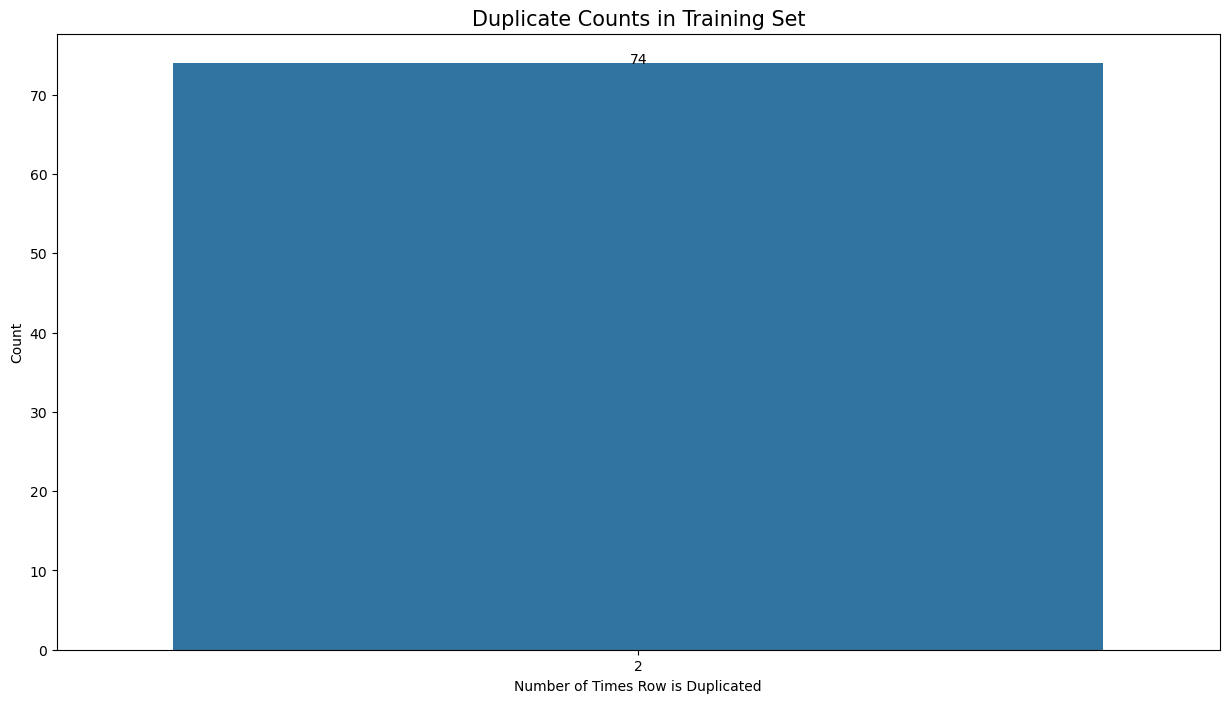

In [13]:
duplicates = train.pivot_table(index=[
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts = dict(zip(unique, counts))

if len(unique) == 1:
    print(": There are no duplicated rows in the training set")
else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

    _ = sns.barplot(x=list(value_counts.keys())[1:], y=list(value_counts.values())[1:], ax=ax)
    _ = ax.set_title("Duplicate Counts in Training Set", fontsize=15)
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("Number of Times Row is Duplicated")
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+(p.get_width()/2),
            y=height,
            s="{:d}".format(int(height)),
            ha="center"
        )

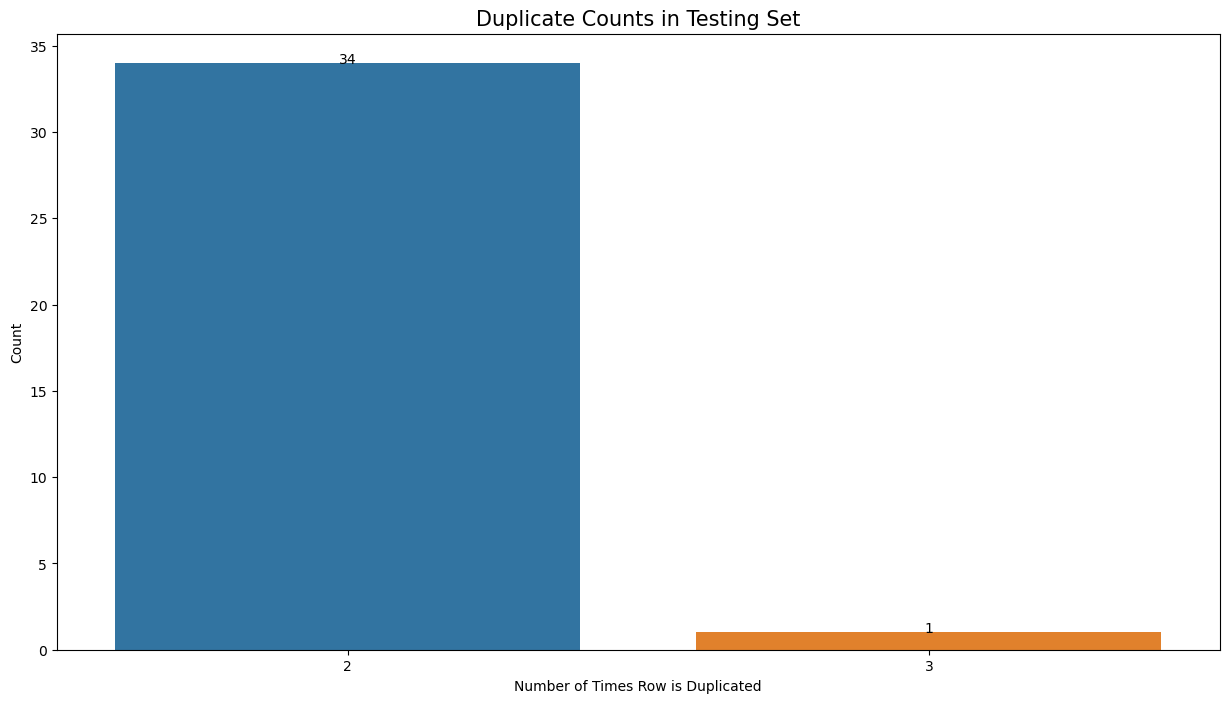

In [14]:
duplicates = test.pivot_table(index=[
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts = dict(zip(unique, counts))

if len(unique) == 1:
    print(": There are no duplicated rows in the testing set")
else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

    _ = sns.barplot(x=list(value_counts.keys())[1:], y=list(value_counts.values())[1:], ax=ax)
    _ = ax.set_title("Duplicate Counts in Testing Set", fontsize=15)
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("Number of Times Row is Duplicated")
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+(p.get_width()/2),
            y=height,
            s="{:d}".format(int(height)),
            ha="center"
        )

 duplicates between the training and testing sets.

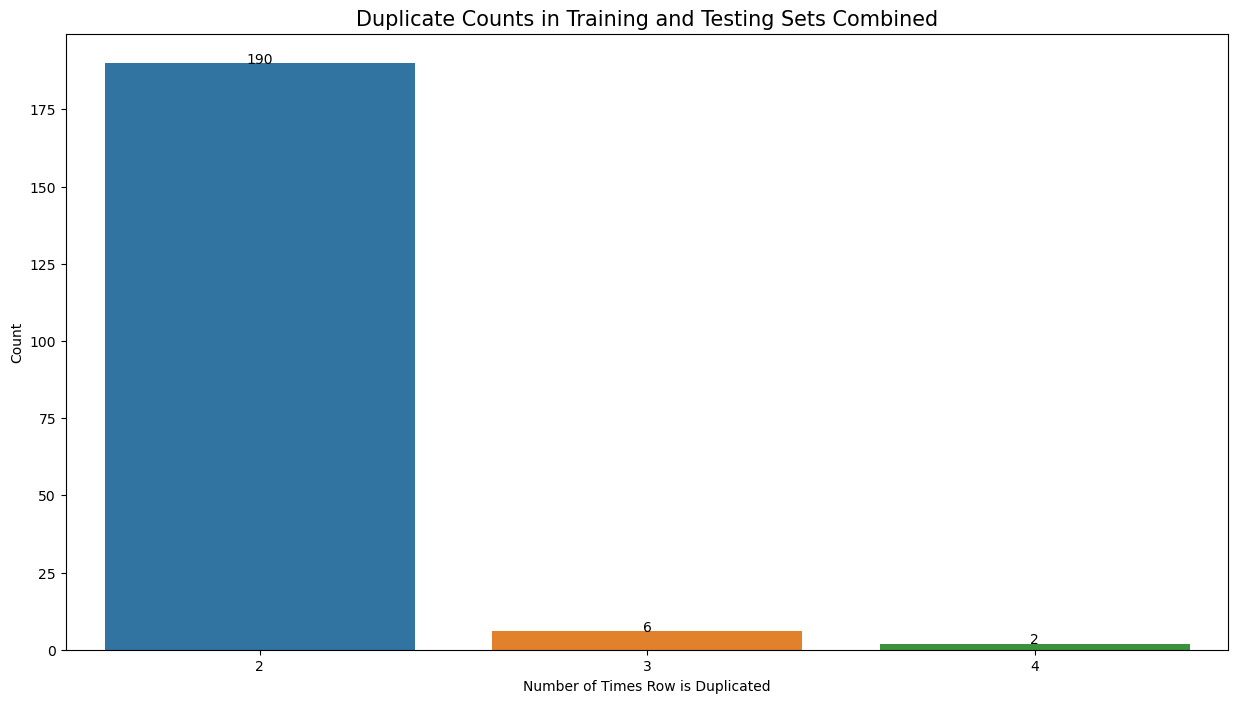

In [15]:
combined = pd.concat([train, test]).reset_index(drop=True)

duplicates = combined.pivot_table(index=[
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts = dict(zip(unique, counts))

if len(unique) == 1:
    print(": There are no duplicated rows in the combined set")
else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

    _ = sns.barplot(x=list(value_counts.keys())[1:], y=list(value_counts.values())[1:], ax=ax)
    _ = ax.set_title("Duplicate Counts in Training and Testing Sets Combined", fontsize=15)
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("Number of Times Row is Duplicated")
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+(p.get_width()/2),
            y=height,
            s="{:d}".format(int(height)),
            ha="center"
        )

This is an interesting result, since it demonstrates that there is duplicate column overlap between training and testing in the order of over 170 rows. If this is the case, then we may be able to copy the prediction result directly from the training set to the testing set to boost our classifier performance. If we take a closer look at the rows that are duplicated:

In [16]:
train['origin'] = "train"
test['origin'] = "test"
combined = pd.concat([train, test]).reset_index(drop=True)

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

pd.set_option('display.max_rows', 70)
combined[combined.duplicated(subset=features, keep=False)].sort_values(by=features)

id  CustomerId     Surname  CreditScore Geography  Gender   Age  \
54189    54189    15732778       Ahern          745    France  Female  28.0   
183067  183067    15732610       Ahern          745    France  Female  28.0   
82551    82551    15627262  Alexandrov          608    France    Male  31.0   
168641  168641    15665790  Alexandrov          608    France    Male  31.0   
91873    91873    15694852      Arcuri          575    France    Male  29.0   
...        ...         ...         ...          ...       ...     ...   ...   
118065  118065    15720968       Young          606   Germany    Male  27.0   
7329      7329    15799186    Zaytseva          624    France  Female  38.0   
182319  182319    15604891    Zaytseva          624    France  Female  38.0   
81817    81817    15799217    Zetticci          791   Germany  Female  35.0   
154530  154530    15799785    Zetticci          791   Germany  Female  35.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
54189        2       0.00              2        1.0             0.0   
183067       2       0.00              2        1.0             0.0   
82551        7   79962.92              2        1.0             0.0   
168641       7   79962.92              2        1.0             0.0   
91873        4  121823.40              2        1.0             1.0   
...        ...        ...            ...        ...             ...   
118065       2  130274.26              2        1.0             1.0   
7329         8       0.00              2        1.0             0.0   
182319       8       0.00              2        1.0             0.0   
81817        7   52436.20              1        1.0             0.0   
154530       7   52436.20              1        1.0             0.0   

        EstimatedSalary  Exited origin  
54189         154389.18     0.0  train  
183067        154389.18     NaN   test  
82551          60901.72     0.0  train  
168641         60901.72     NaN   test  
91873          50368.63     1.0  train  
...                 ...     ...    ...  
118065        147533.09     0.0  train  
7329           95403.41     0.0  train  
182319         95403.41     NaN   test  
81817         161051.75     1.0  train  
154530        161051.75     0.0  train  

[406 rows x 15 columns]

# Key Observations about Duplicated Rows
There appear to be training samples that we may have a direct target for in the training set:
Surname of Ahern with a credit score of 745 appears in both the training and testing sets.
If we assume the target column of Exited is the same for the both, then we can use the training target as our test prediction.
There is evidence however, that the duplicate columns may have different mappings to Exited:
Surname of Zetticci with a credit score of 791 appears in the training set twice, with the only difference being the target value of Exited.
This duplicate outcome is likely to confuse our classifier, since one is a positive example, and the other is negative.
Depending on how these duplicates were created, if we assume for a moment that these were meant to be distinct rows of data, then we can make the opposite prediction from the training set in the testing set. We can test this empirically by burning a few submissions to see how it impacts score.

# Class Imbalance

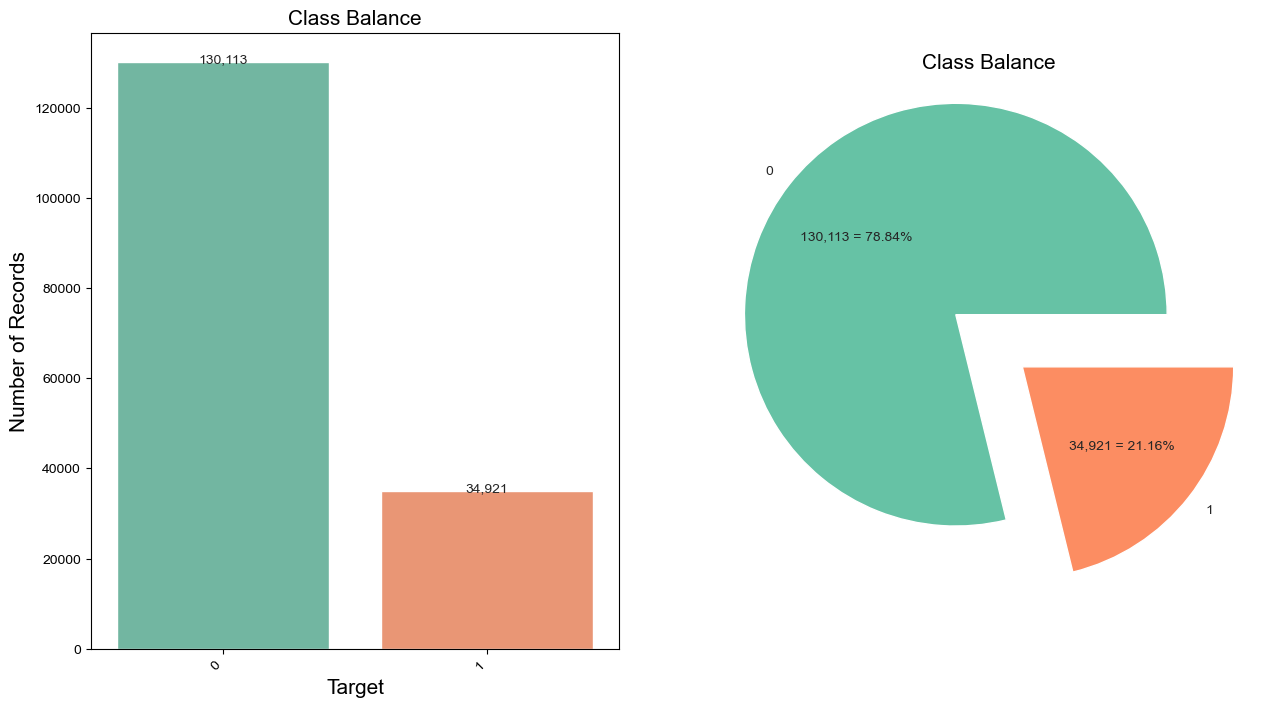

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

counts = pd.DataFrame({"Exited": [train["Exited"].value_counts()[0], train["Exited"].value_counts()[1]]})
_ = sns.barplot(x=counts.index, y=counts.Exited, ax=axs[0])
for p in axs[0].patches:
    axs[0].text(x=p.get_x()+(p.get_width()/2), y=p.get_height(), s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[0].set_title("Class Balance", fontsize=15)
_ = axs[0].set_ylabel("Number of Records", fontsize=15)
_ = axs[0].set_xlabel("Target", fontsize=15)
for label in axs[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

targets = train["Exited"].unique()
data = [train[(train["Exited"] == target)]["id"].count() for target in targets]
_ = axs[1].pie(
    data, labels=targets,
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
    explode=[0.20] * len(data), 
    colors=sns.color_palette("Set2")[0:len(data)],
)
_ = axs[1].set_title("Class Balance", fontsize=15)

# Key Observations about Class Balance
As we can see, the dataset is heavily skewed to an Exited value of 0.
Detecting Exited values of 1 is likely going to be difficult, as they are rare when compared to the negative class.

# Feature Exploration

# Surname
The Surname feature of the dataset provides the last name of the customer. In terms of usefulness, the Spearman correlation suggested that it was positively correlated with bank balance. Balance in turn was correlated with our target variable. A combination of these features may provide us some insights. First, let's look to see how many unique last names we are dealing with.

In [18]:
print(f": Number of unique surnames = {train['Surname'].nunique():,d}")

: Number of unique surnames = 2,797


This is interesting given there are 165,034 rows of data. This means there is a lot of overlap between last name and number of records. Let's take a look at the top 24 surnames and see if there are any that stick out as having higher correlation to the target.

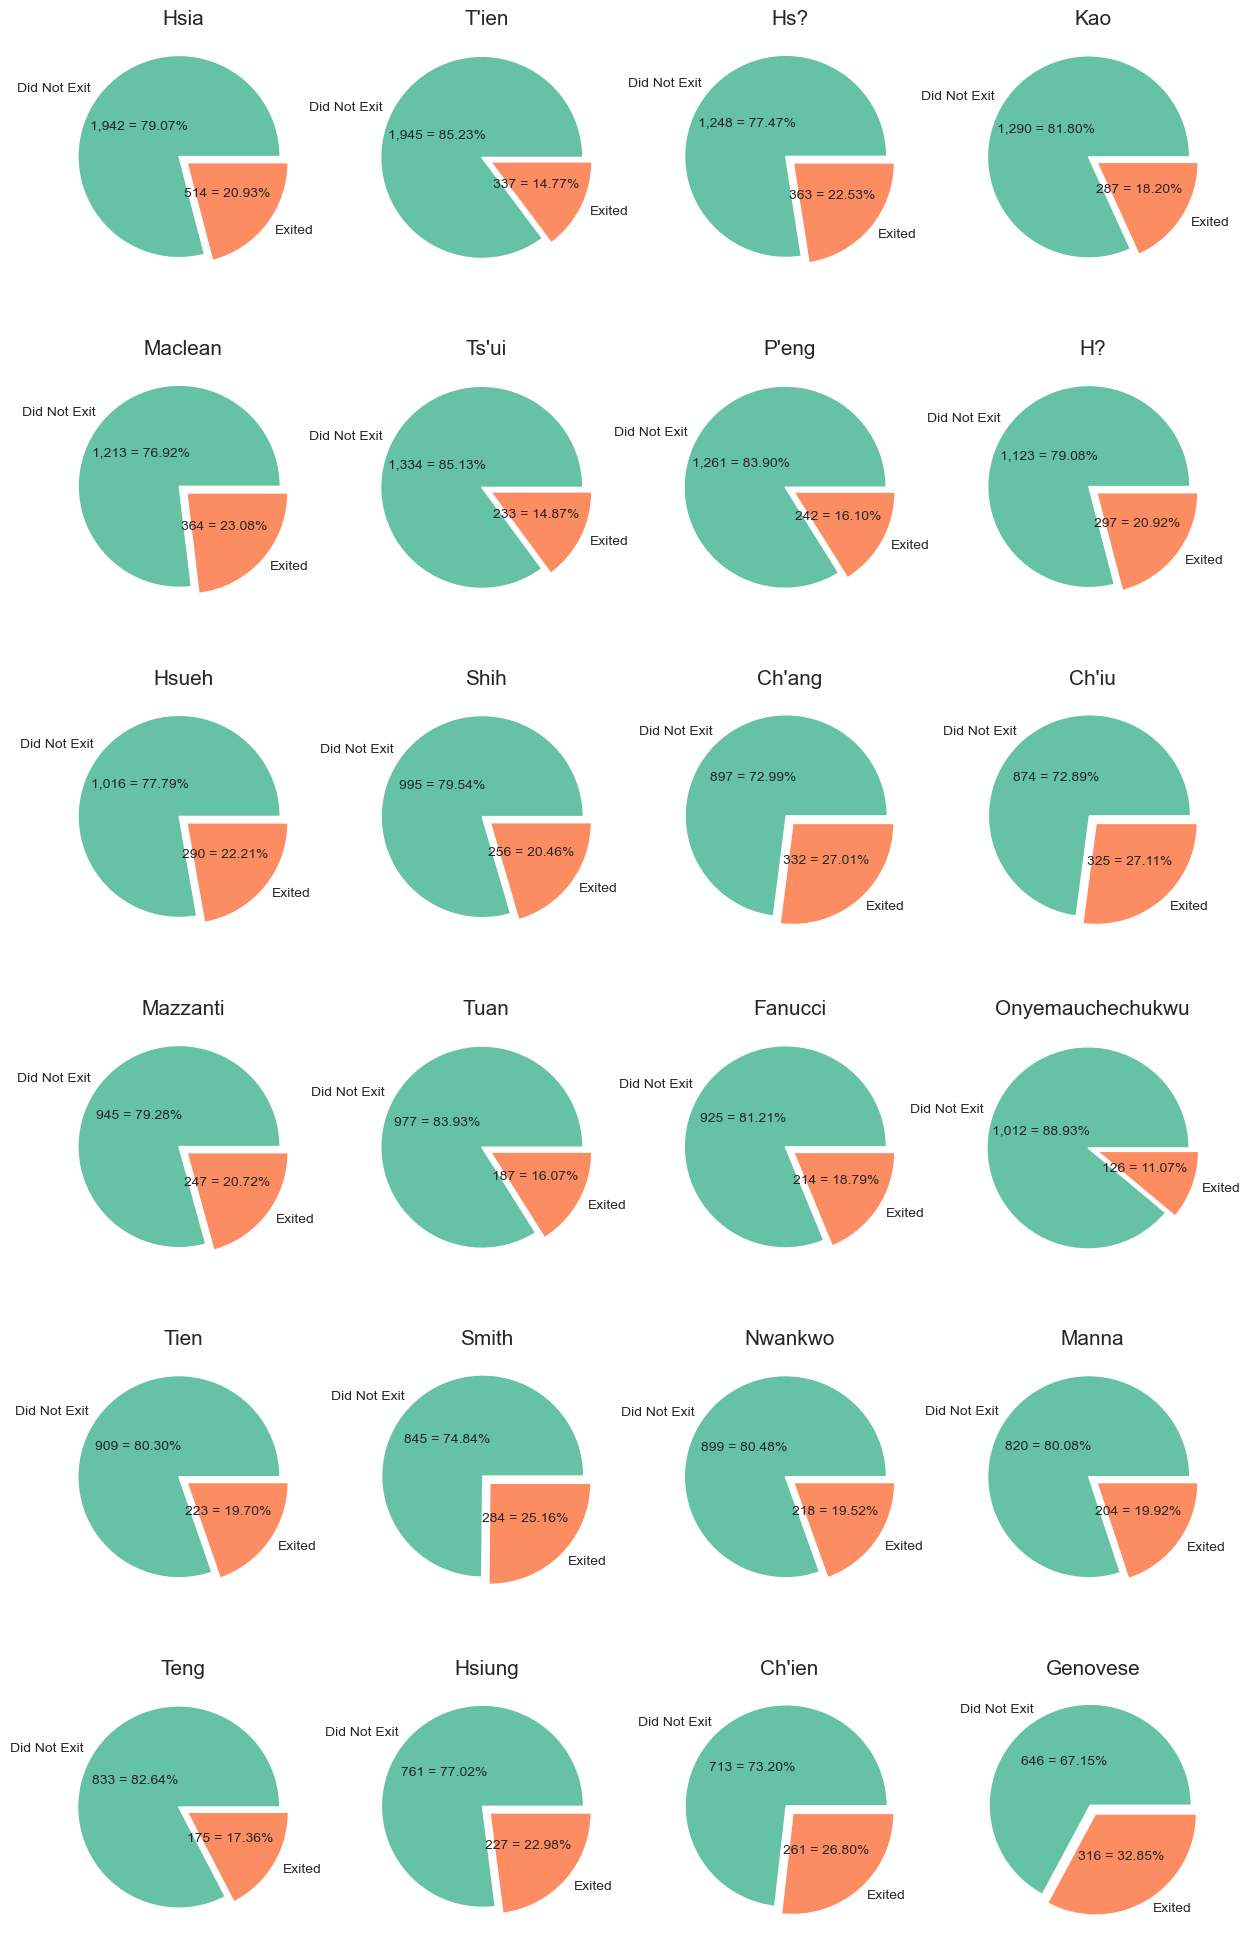

In [19]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(15, 25))

sns.set_style('darkgrid')
sns.set_palette('Set2')

top_surnames = [surname for surname in train["Surname"].value_counts().nlargest(24).index]
labels = top_surnames.copy()
axs = axs.flatten()

for ag, surname in enumerate(top_surnames):
    data = [
        train[(train["Exited"] == 0) & (train["Surname"] == surname)]["id"].count(),
        train[(train["Exited"] == 1) & (train["Surname"] == surname)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=label,
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{labels[ag]}", fontsize=15)
    
axs[5].set_axis_off()

As we can see, there are no magic bullets. Some notable surnames such as Genovese and Ch'ang have slightly higher Exited occurrences than their counterparts, while Onyemauchechukwu has a much smaller number of Exited occurrences. Gradient boosted decision trees may be able to exploit this if we make use of label encoding.

Strangely though, if we think about surnames and their impact on whether someone leaves the bank, we would expect name to have no impact on the actual result. In other words, in our pie chart, we would expect the different surnames to exit the bank at roughly the same proportions as each other, but clearly this is not the case (for example with Genovese). If we examine the surnames closer as well, we find some oddities, such as H? and Hs?. We may be seeing artifacts of the synthetic data generation scheme at work. What happens if we roll up surnames to first letter only and look at their breakdown of exiting the bank?

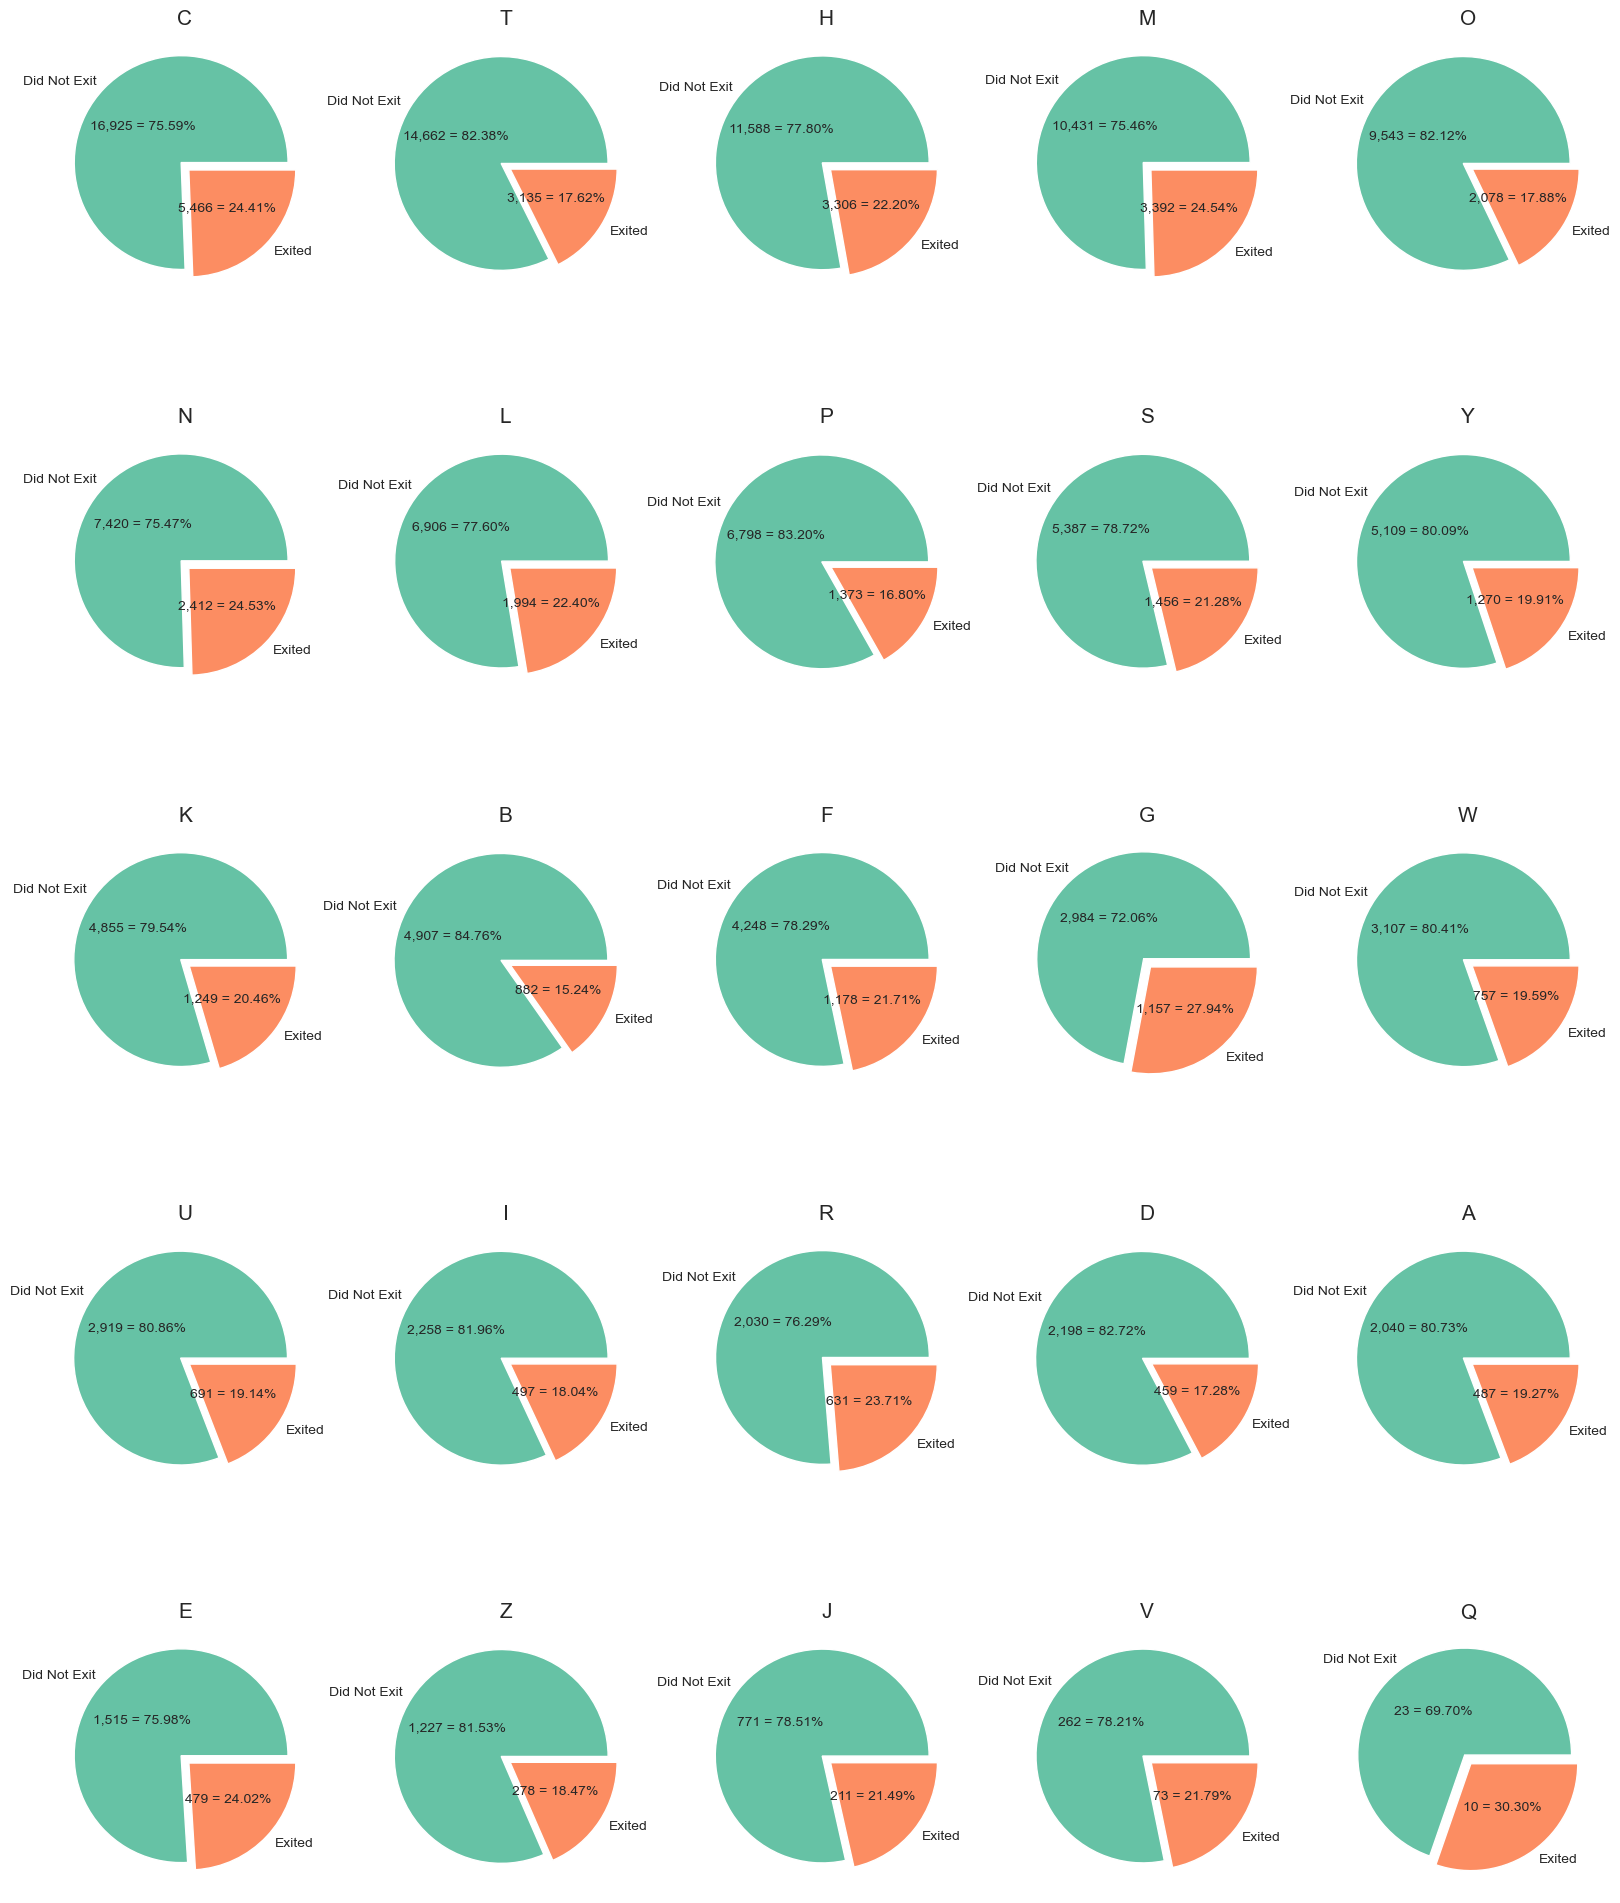

In [20]:
train["Surname_First_Letter"] = train["Surname"].apply(lambda x: x[0])

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

sns.set_style('darkgrid')
sns.set_palette('Set2')

top_surnames = [surname for surname in train["Surname_First_Letter"].value_counts().index]
labels = top_surnames.copy()
axs = axs.flatten()

for ag, surname in enumerate(top_surnames):
    data = [
        train[(train["Exited"] == 0) & (train["Surname_First_Letter"] == surname)]["id"].count(),
        train[(train["Exited"] == 1) & (train["Surname_First_Letter"] == surname)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=label,
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{labels[ag]}", fontsize=15)
    
axs[5].set_axis_off()

Again, we can see that if the surname starts with Q, they are much more likely to leave the bank (however, this can partly be explained by the small numbers of samples in those groups). But if we look at surnames that start with T and surnames that start with C, we can see a stark difference between those exit numbers. We may want to experiment with first letter surnames as a feature in the classifier to see if it provides lift.



# Key Observations about Surname
Surname field alone is likely not going to be too helpful in generating lift for our classifier.
We may be able to combine Surname with other fields to see if there is benefit.
Different types of categorical encoding may make a difference to our classifier.
Using only the first letter in the surname as a feature may provide lift.

# CreditScore
The CreditScore feature of the data appears to correlate with the patron's real world credit score. According to Investopedia a credit score is used as a general guideline to determine whether an individual is a good credit risk (i.e. if they should be given financial credit). The score ranges in values between 300 and 850. Scoring higher means that an individual will likely have a better chance at securing various forms and amounts of credit. Usually those with lower values of credit scores are more likely to make payments late, owe larger amounts, have shorter credit histories, or have too many other lines of credit open.

In terms of relating a credit score to churn, our Spearman correlation showed us that the raw score did not appear to have a strong positive or negative correlation to the target variable. However, there may be ways of segmenting or otherwise modifying the credit score to be more informative. Let's look first at some density estimates to see where the bulk of our credit scores are located.

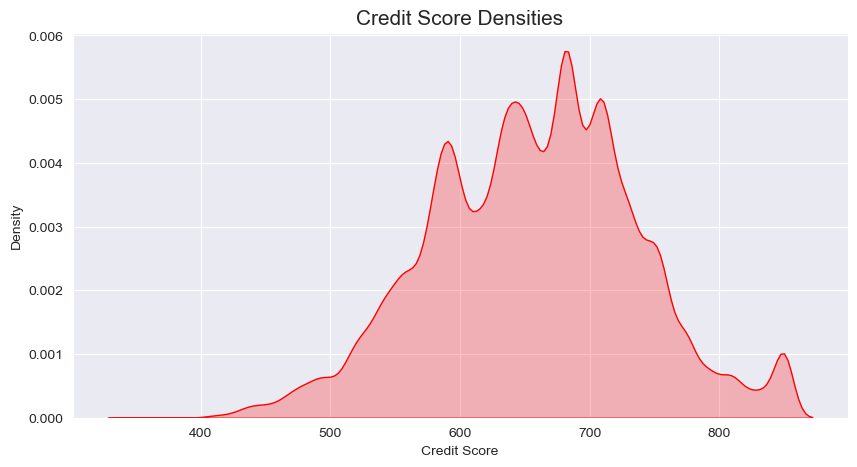

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

_ = sns.kdeplot(train["CreditScore"], shade=True, color="r", ax=axs, label="Credit Score Densities")
_ = axs.set_title("Credit Score Densities", fontsize=15)
_ = axs.set_ylabel("Density")
_ = axs.set_xlabel("Credit Score")

As was indicated on our statistical breakdown above, the bulk of our scores occur around the 650 mark, and tend not to stray too much below 580. This provides us a unique insight based on Investopedia, where credit scores can be categorized into good versus poor risks for credit:

300 - 579 = Poor
580 - 669 = Fair
670 - 739 = Good
740 - 799 = Very Good
800 - 850 = Excellent
This suggests we may be able to create a new column that segments patrons into different credit ranges, and use that as a feature. Let's look at whether this will be helpful.

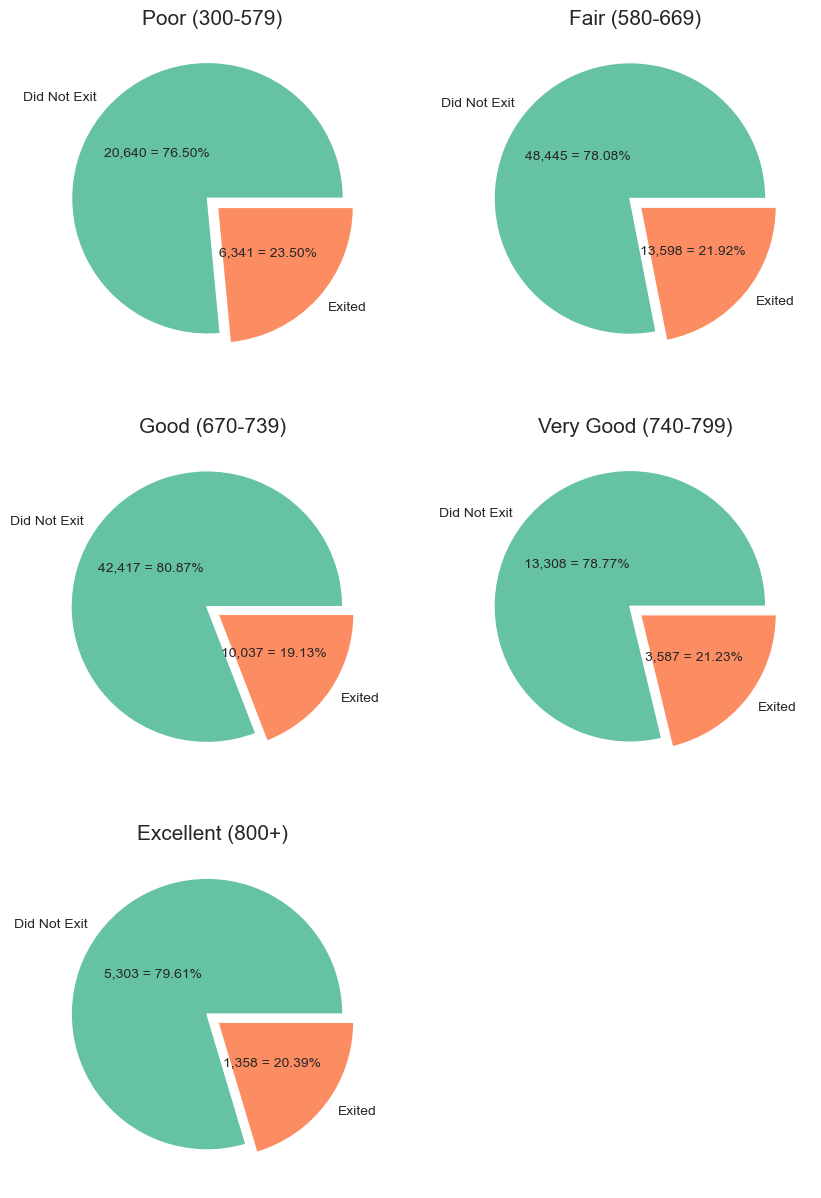

In [22]:
ig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

credit_score_ranges = [(300, 579), (579, 669), (669, 739), (739, 799), (799, 950)]
labels = ["Poor (300-579)", "Fair (580-669)", "Good (670-739)", "Very Good (740-799)", "Excellent (800+)"]
axs = axs.flatten()

for ag, credit_score in enumerate(credit_score_ranges):
    data = [
        train[(train["Exited"] == 0) & (train["CreditScore"] >= credit_score[0]) & (train["CreditScore"] < credit_score[1])]["id"].count(),
        train[(train["Exited"] == 1) & (train["CreditScore"] >= credit_score[0]) & (train["CreditScore"] < credit_score[1])]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=label,
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{labels[ag]}", fontsize=15)
    
axs[5].set_axis_off()

A little bit of insight comes from the fact that Germany appears to have a higher number of patrons that exit a bank than others do. Alone this may not be enough of an insight to provide our classifier with any lift, but in combination with other risk factors, it may provide a second-order feature that provides lift.

While our Spearman correlation didn't show strong connection to Exited, it did however have a strong correlation to Balance, which in turn does have a high connection to Exited. Let's take a look for a moment at Balance and Geography.

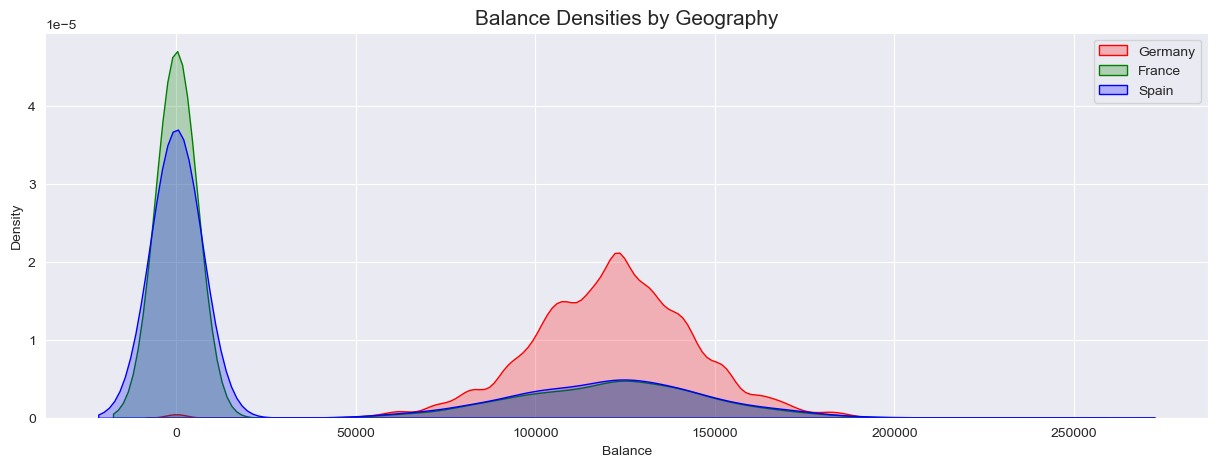

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

_ = sns.kdeplot(train[(train["Geography"] == "Germany")]["Balance"], shade=True, color="r", ax=axs, label="Germany")
_ = sns.kdeplot(train[(train["Geography"] == "France")]["Balance"], shade=True, color="g", ax=axs, label="France")
_ = sns.kdeplot(train[(train["Geography"] == "Spain")]["Balance"], shade=True, color="b", ax=axs, label="Spain")
_ = axs.set_title("Balance Densities by Geography", fontsize=15)
_ = axs.set_ylabel("Density")
_ = axs.set_xlabel("Balance")
_ = axs.legend()

As we can see, there is a very noticeable difference in terms of balance distributions between various geographies, with Germany being the one geography that has the bulk of it's balances sitting at roughly $125,000. Again, this doesn't help us with the Exited value, but it does show us there are differences between geographic locations.

# Key Insights about Geography
The breakdown of Exited by geography didn't provide a clear indicator for our classifier.
However, we may be able to use Germany as a risk factor calculation, since it is clear that people leaving occurs more in Germany than other geographic locations.

#  Gender
Our Spearman correlation showed us that there was a weak negative correlation between the Gender feature and Exited. Let's take a look at gender versus our target to see if there is anything interesting.

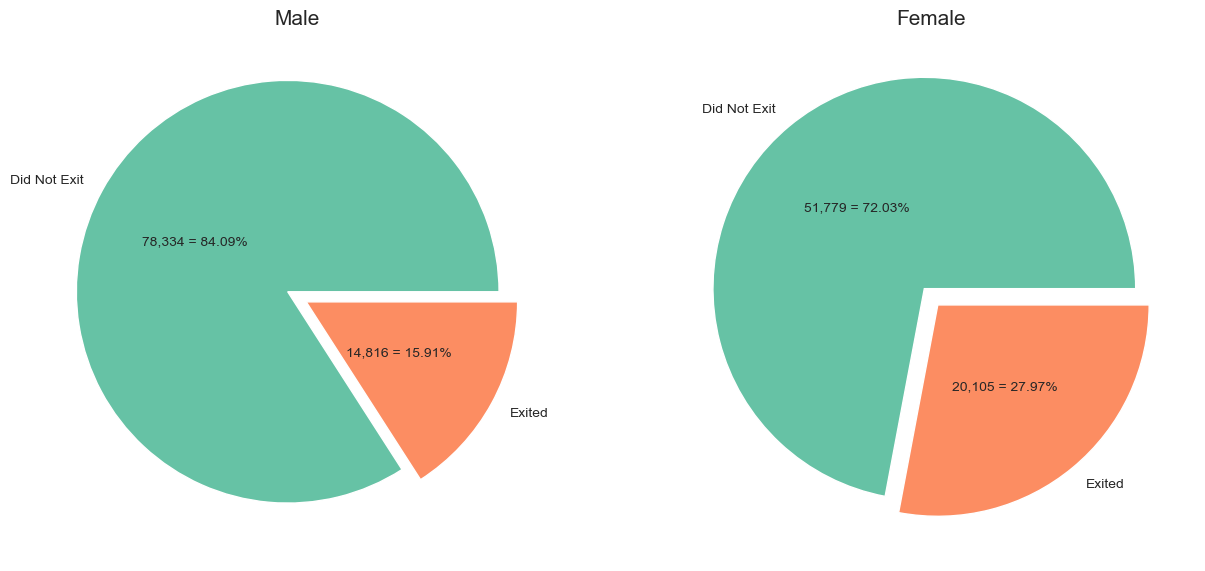

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

genders = [place for place in train['Gender'].unique()]
axs = axs.flatten()

for ag, gender in enumerate(genders):
    data = [
        train[(train["Exited"] == 0) & (train["Gender"] == gender)]["id"].count(),
        train[(train["Exited"] == 1) & (train["Gender"] == gender)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=["Did Not Exit", "Exited"],
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{gender}", fontsize=15)


As we can see, patrons who are Male are much more likely to stay with the bank when compared with those that are Female. The question is whether there are even clearer indications of when Male patrons may leave. Let's take a look at Gender combined with Geography. Specifically, let's look at Male patrons, since they have a different likelihood of exiting.

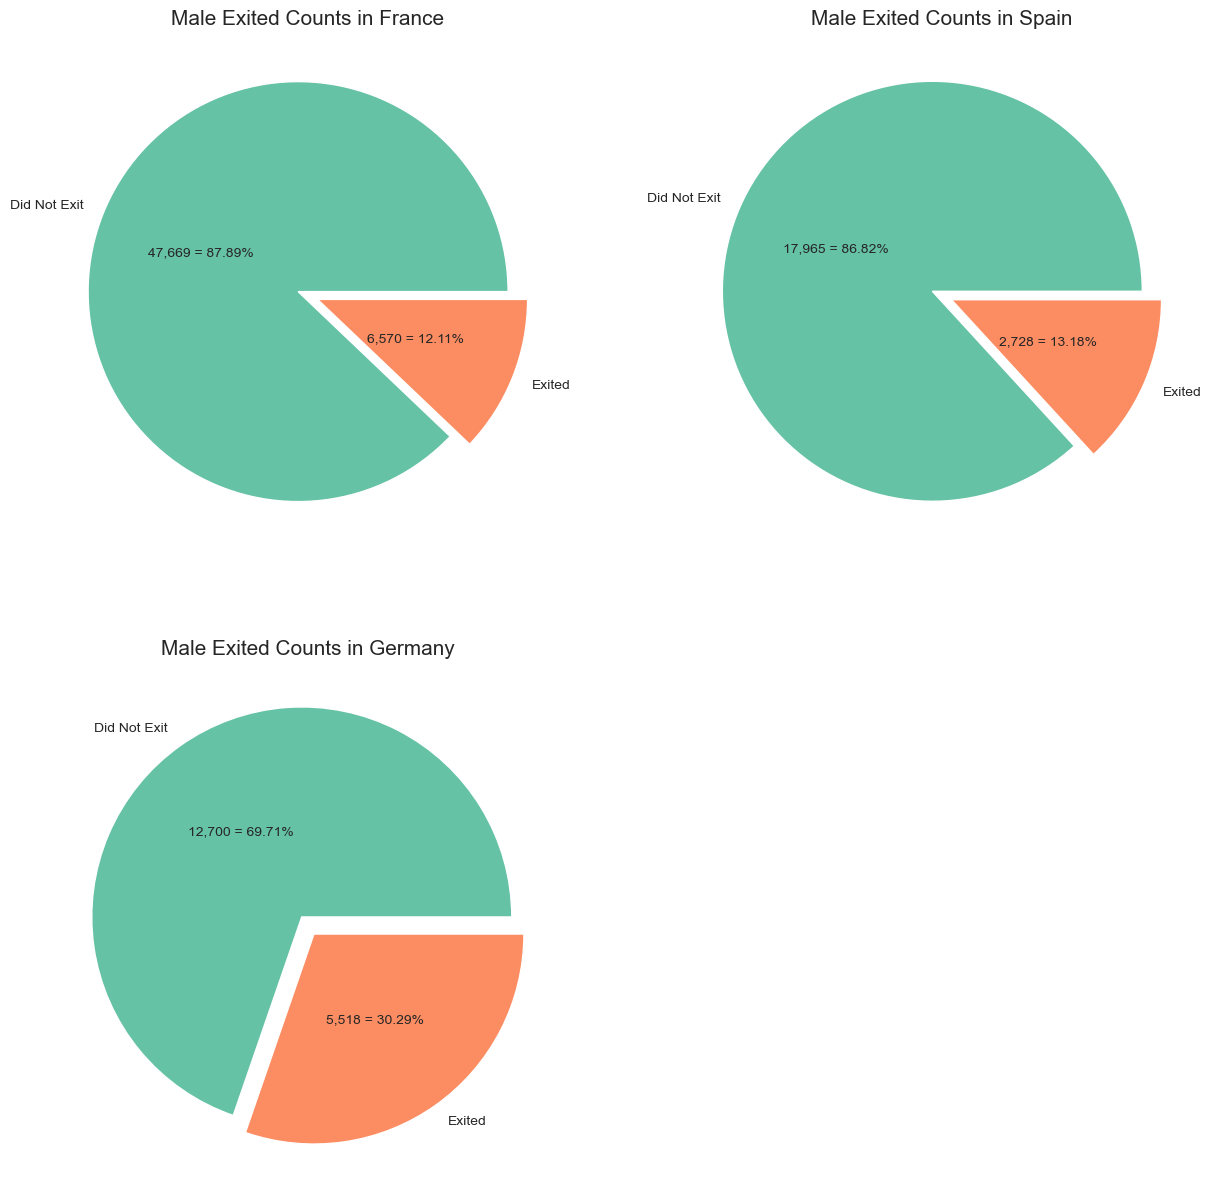

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

geographies = [place for place in train['Geography'].unique()]
axs = axs.flatten()

for ag, geography in enumerate(geographies):
    data = [
        train[(train["Exited"] == 0) & (train["Geography"] == geography) & (train["Gender"] == "Male")]["id"].count(),
        train[(train["Exited"] == 1) & (train["Geography"] == geography) & (train["Gender"] == "Male")]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=["Did Not Exit", "Exited"],
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"Male Exited Counts in {geography}", fontsize=15)
    
axs[3].set_axis_off()

Again, we see lower numbers of males exiting from France and Spain. Again, this is not a strong enough indicator on its own, but could be combined into a mitigating factors feature that counts the number of items that make it more likely that a patron will stay with the bank. Again, models such as Gradient Boosting Decision Tree approaches are very likely to find this connection without any further input or processing. Let's take a look for a moment at balances.

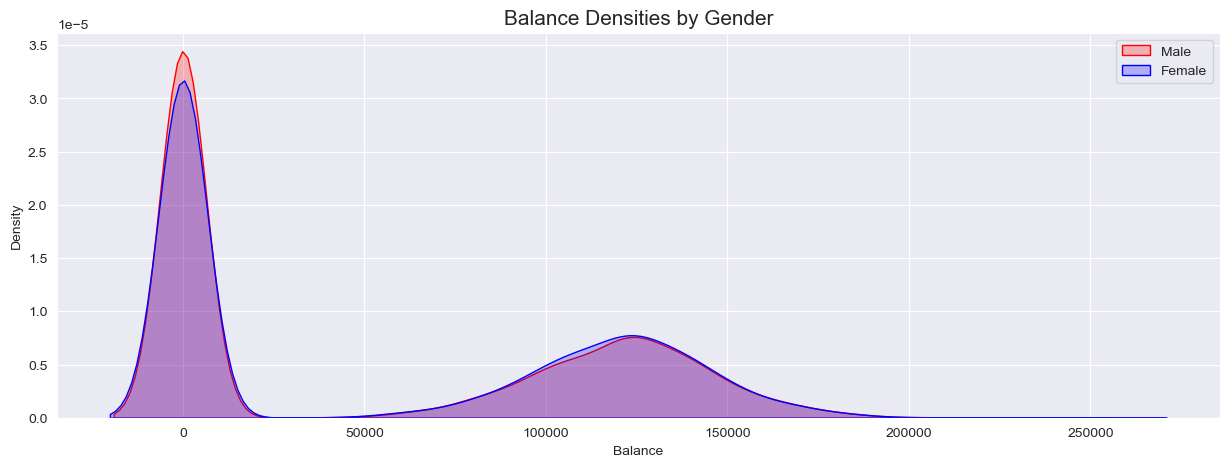

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

_ = sns.kdeplot(train[(train["Gender"] == "Male")]["Balance"], shade=True, color="r", ax=axs, label="Male")
_ = sns.kdeplot(train[(train["Gender"] == "Female")]["Balance"], shade=True, color="b", ax=axs, label="Female")
_ = axs.set_title("Balance Densities by Gender", fontsize=15)
_ = axs.set_ylabel("Density")
_ = axs.set_xlabel("Balance")
_ = axs.legend()

We see nearly identical balance densities. If we break this down further by geographical location:

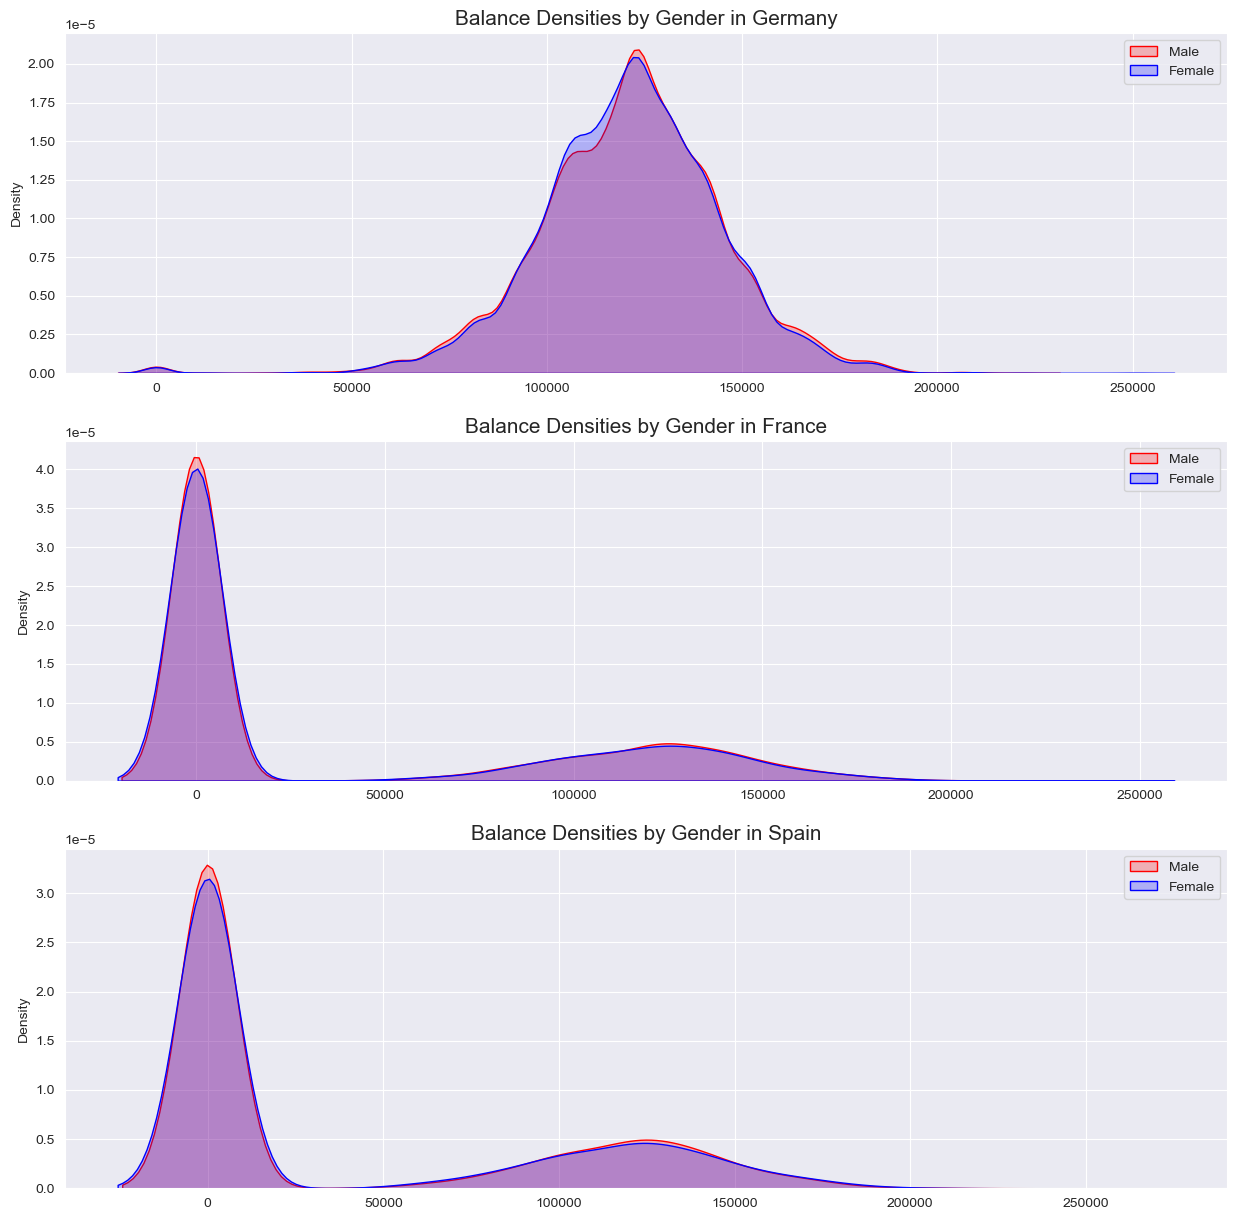

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

_ = sns.kdeplot(train[(train["Gender"] == "Male") & (train["Geography"] == "Germany")]["Balance"], shade=True, color="r", ax=axs[0], label="Male")
_ = sns.kdeplot(train[(train["Gender"] == "Female") & (train["Geography"] == "Germany")]["Balance"], shade=True, color="b", ax=axs[0], label="Female")
_ = axs[0].set_title("Balance Densities by Gender in Germany", fontsize=15)
_ = axs[0].set_ylabel("Density")
_ = axs[0].set_xlabel("")
_ = axs[0].legend()

_ = sns.kdeplot(train[(train["Gender"] == "Male") & (train["Geography"] == "France")]["Balance"], shade=True, color="r", ax=axs[1], label="Male")
_ = sns.kdeplot(train[(train["Gender"] == "Female") & (train["Geography"] == "France")]["Balance"], shade=True, color="b", ax=axs[1], label="Female")
_ = axs[1].set_title("Balance Densities by Gender in France", fontsize=15)
_ = axs[1].set_ylabel("Density")
_ = axs[1].set_xlabel("")
_ = axs[1].legend()

_ = sns.kdeplot(train[(train["Gender"] == "Male") & (train["Geography"] == "Spain")]["Balance"], shade=True, color="r", ax=axs[2], label="Male")
_ = sns.kdeplot(train[(train["Gender"] == "Female") & (train["Geography"] == "Spain")]["Balance"], shade=True, color="b", ax=axs[2], label="Female")
_ = axs[2].set_title("Balance Densities by Gender in Spain", fontsize=15)
_ = axs[2].set_ylabel("Density")
_ = axs[2].set_xlabel("")
_ = axs[2].legend()

Again, balance densities are very similar between genders regardless of geography.

# Key Observations about Gender
Males are far less likely to exit the bank.
This holds true in both Spain and France.
Males in Germany are much more likely to exit when compared to other geographies.
Males and females have very similar balances.

# Age
First of all, let's take a look at just the Age feature alone to see whether we have class separation

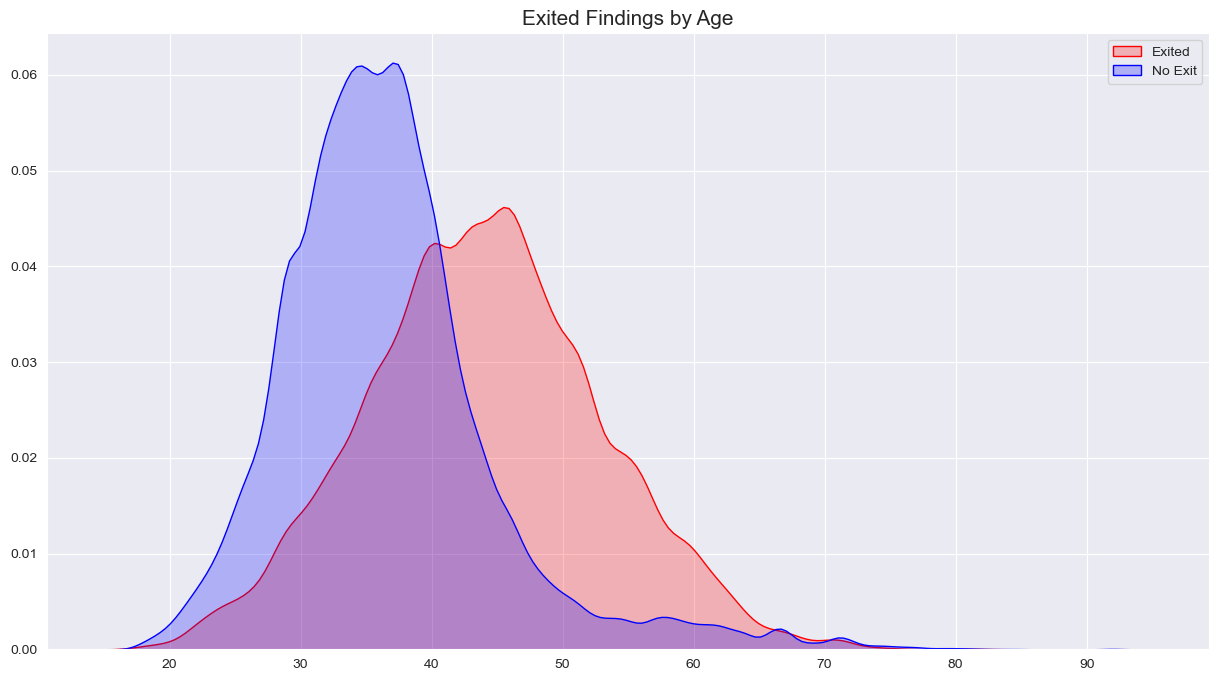

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["Exited"] == 1)]["Age"], shade=True, color="r", ax=ax, label="Exited")
_ = sns.kdeplot(train[(train["Exited"] == 0)]["Age"], shade=True, color="b", ax=ax, label="No Exit")
_ = ax.set_title("Exited Findings by Age".format(feature), fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:2], labels=labels[0:2], title="")


We have two very distinct age densities associated with Exited. As we can see, those aged 25-35 are likely to remain with the bank, while those aged 40 - 65 are more likely to exit. This finding is consistent with our Spearman correlation, which suggested that higher ages were more strongly correlated with the target. As a first-order feature, this is good news, since it suggests that one of the best indicators of churn is age. Much like our Geography column, we can also use this as an absolute value for a risk factor. If age is greater than 40, an additional risk factor exists.

The question is whether we can gain additional lift by enhancing the feature with other continuous columns. A good candidate is the number of products that the user has, since our Spearman correlation said that the number of products was negatively correlated with the target variable (the more products a patron has, the less likely they are to leave). If we exaggerate age by number of products, we may be able to gain class separation.

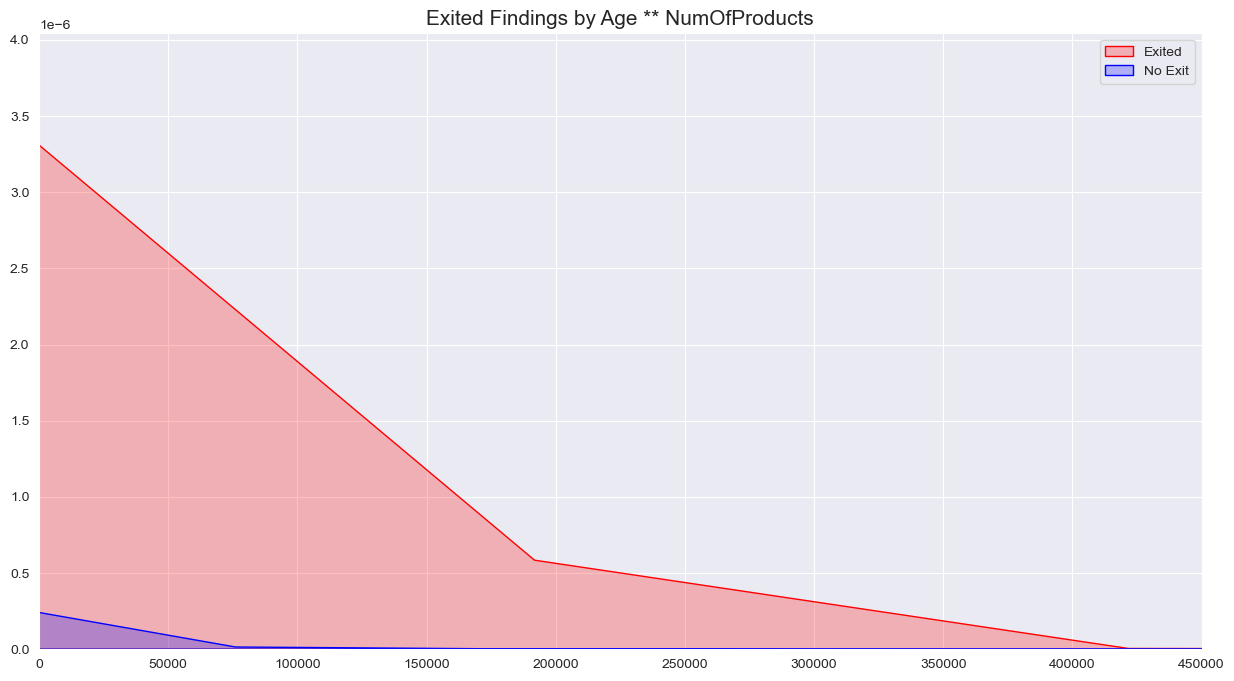

In [29]:
train["Age_NumOfProducts"] =  train["Age"] ** train["NumOfProducts"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["Exited"] == 1)]["Age_NumOfProducts"], shade=True, color="r", ax=ax, label="Exited")
_ = sns.kdeplot(train[(train["Exited"] == 0)]["Age_NumOfProducts"], shade=True, color="b", ax=ax, label="No Exit")
_ = ax.set_title("Exited Findings by Age ** NumOfProducts".format(feature), fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
_ = ax.set_xlim(0, 0.045e7)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:2], labels=labels[0:2], title="")

# Key Observations about Age
Age is a strong indicator for our target.
We may be able to create an additional risk factor based on age.
Age combined with number of products may provide lift as an additional feature.

# Tenure
Tenure refers to how long a patron has been with the institution. Let's take a look at raw tenure numbers and see how they pan out.

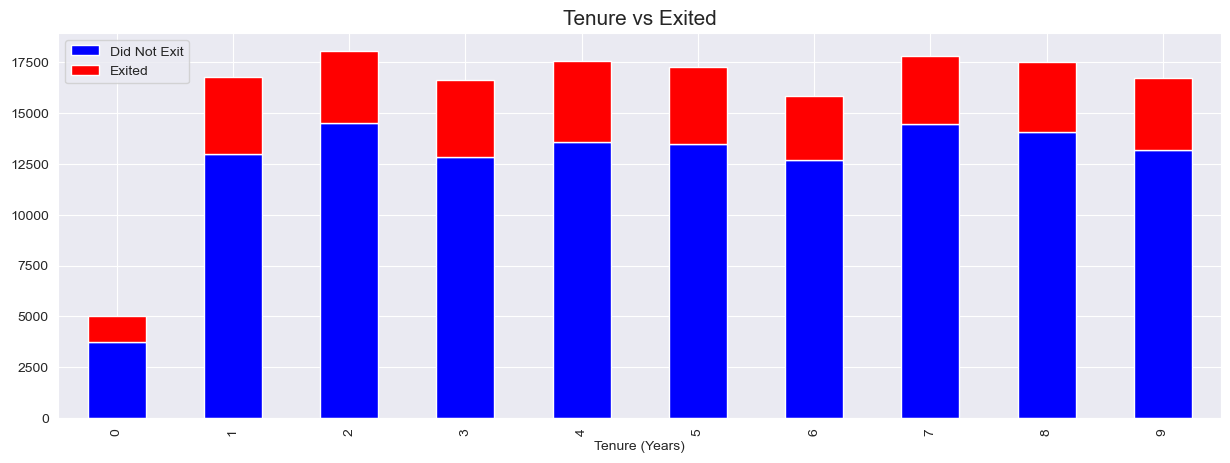

In [30]:
def bin_data(data, bin_defs):
    counts = []
    for bin_def in bin_defs:
        counts.append(((data >= bin_def[0]) & (data < bin_def[1])).sum())
    return counts
bin_defs = []
labels = []
step_size = 1
for x in range(0, 10, step_size):
    bin_defs.append([x, x+step_size])
    labels.append(f"{x:d}")
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Did Not Exit': bin_data(train[(train["Exited"] == 0)]["Tenure"], bin_defs),
        'Exited': bin_data(train[(train["Exited"] == 1)]["Tenure"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["blue", "red"], ax=ax)
_ = ax.set_title("Tenure vs Exited", fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("Tenure (Years)")

As we can see, there isn't really a difference in raw tenure years. There are however, a number of ways to look at tenure statistics. First, let's see if there is a difference in Gender.

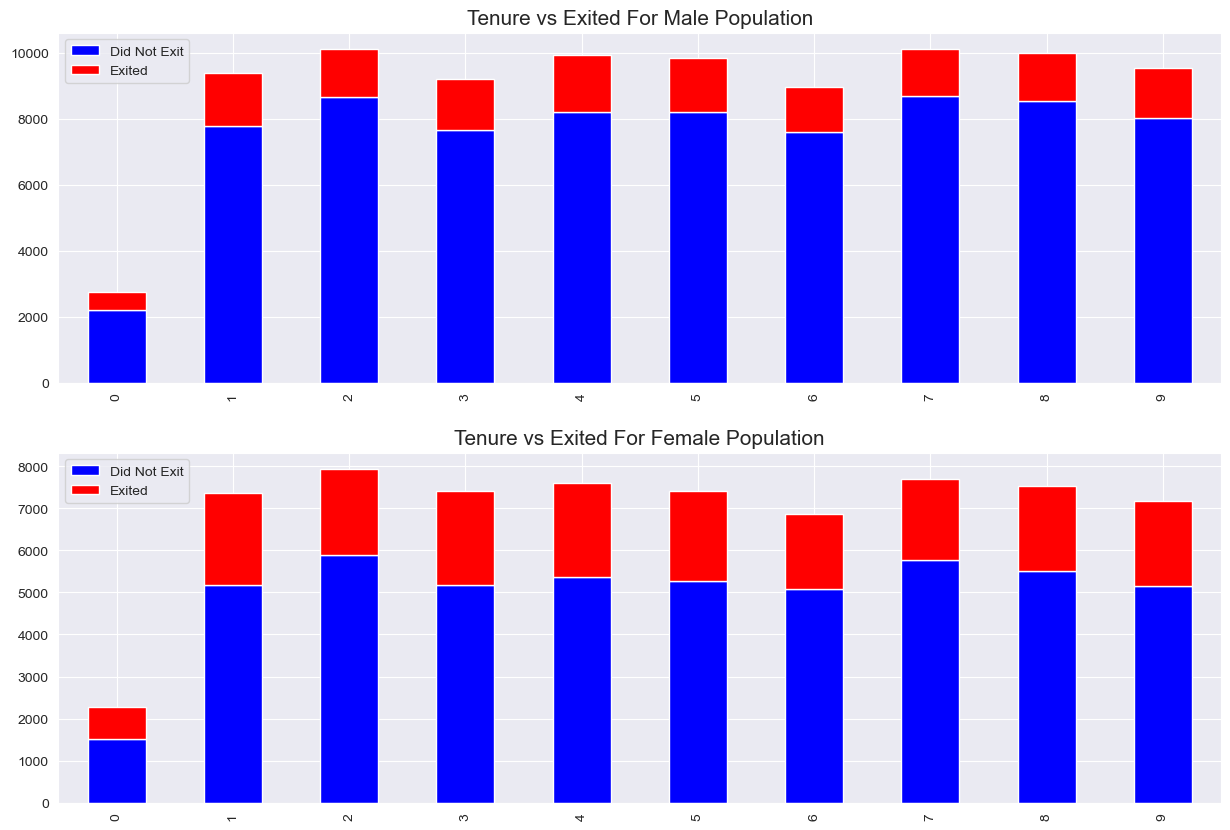

In [31]:
bin_defs = []
labels = []
step_size = 1
for x in range(0, 10, step_size):
    bin_defs.append([x, x+step_size])
    labels.append(f"{x:d}")
    
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Did Not Exit': bin_data(train[(train["Exited"] == 0) & (train["Gender"] == "Male")]["Tenure"], bin_defs),
        'Exited': bin_data(train[(train["Exited"] == 1) & (train["Gender"] == "Male")]["Tenure"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["blue", "red"], ax=axs[0])
_ = axs[0].set_title("Tenure vs Exited For Male Population", fontsize=15)
_ = axs[0].set_ylabel("")
_ = axs[0].set_xlabel("")

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Did Not Exit': bin_data(train[(train["Exited"] == 0) & (train["Gender"] == "Female")]["Tenure"], bin_defs),
        'Exited': bin_data(train[(train["Exited"] == 1) & (train["Gender"] == "Female")]["Tenure"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["blue", "red"], ax=axs[1])
_ = axs[1].set_title("Tenure vs Exited For Female Population", fontsize=15)
_ = axs[1].set_ylabel("")
_ = axs[1].set_xlabel("")

Let's look at tenure based on geography.

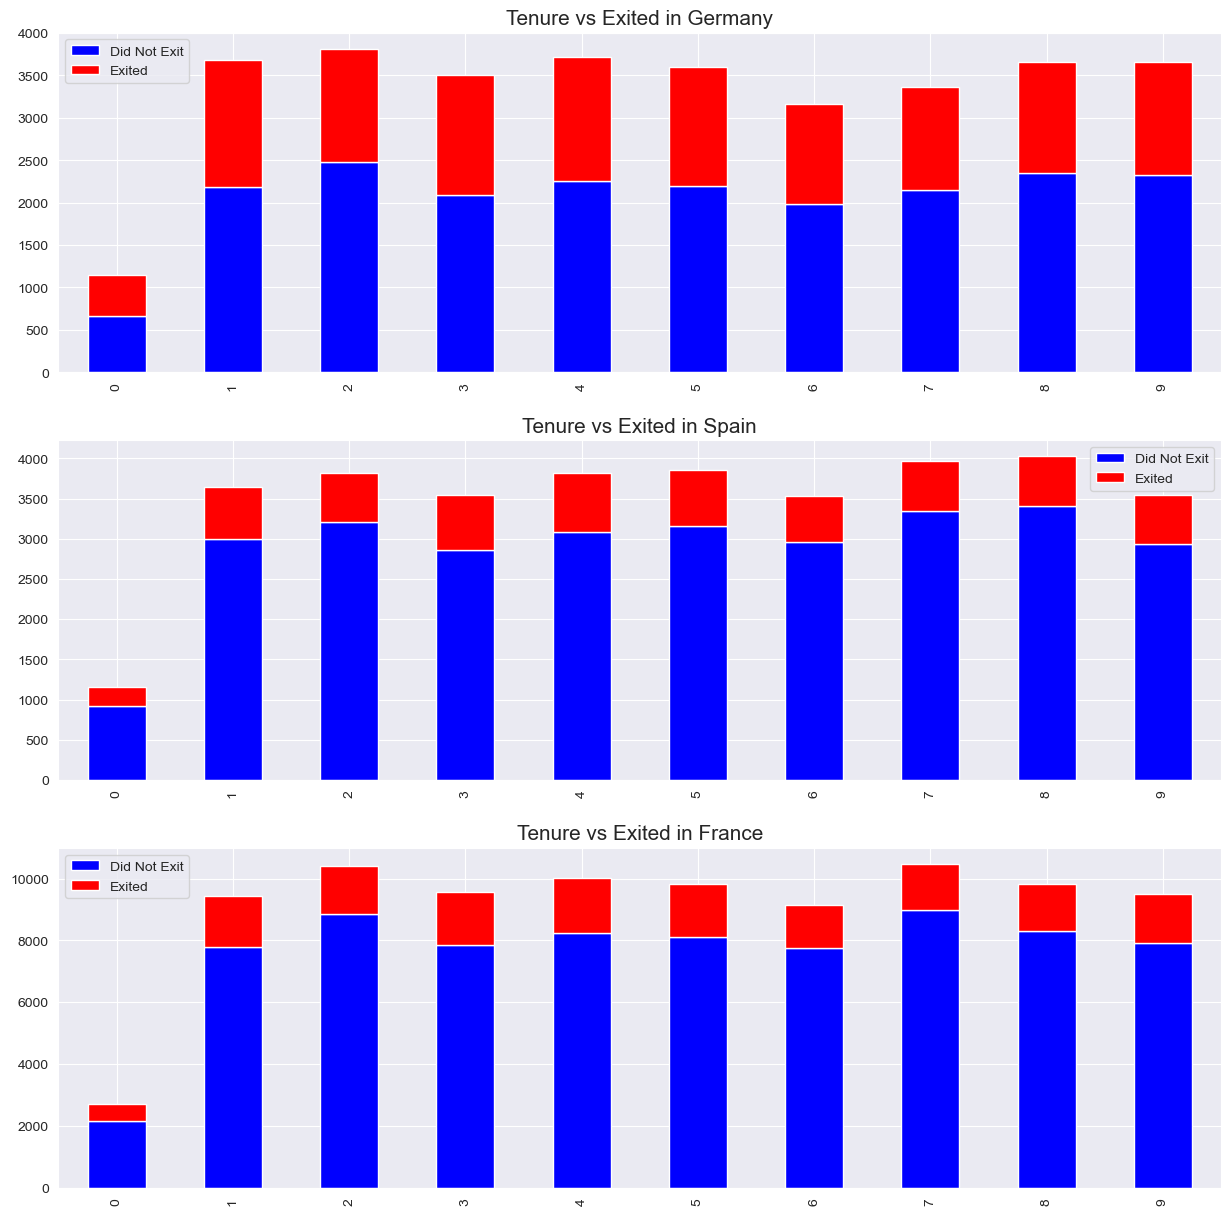

In [32]:
bin_defs = []
labels = []
step_size = 1
for x in range(0, 10, step_size):
    bin_defs.append([x, x+step_size])
    labels.append(f"{x:d}")
    
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Did Not Exit': bin_data(train[(train["Exited"] == 0) & (train["Geography"] == "Germany")]["Tenure"], bin_defs),
        'Exited': bin_data(train[(train["Exited"] == 1) & (train["Geography"] == "Germany")]["Tenure"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["blue", "red"], ax=axs[0])
_ = axs[0].set_title("Tenure vs Exited in Germany", fontsize=15)
_ = axs[0].set_ylabel("")
_ = axs[0].set_xlabel("")

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Did Not Exit': bin_data(train[(train["Exited"] == 0) & (train["Geography"] == "Spain")]["Tenure"], bin_defs),
        'Exited': bin_data(train[(train["Exited"] == 1) & (train["Geography"] == "Spain")]["Tenure"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["blue", "red"], ax=axs[1])
_ = axs[1].set_title("Tenure vs Exited in Spain", fontsize=15)
_ = axs[1].set_ylabel("")
_ = axs[1].set_xlabel("")

tdf = pd.DataFrame(
    {
        'Label': labels,
        'Did Not Exit': bin_data(train[(train["Exited"] == 0) & (train["Geography"] == "France")]["Tenure"], bin_defs),
        'Exited': bin_data(train[(train["Exited"] == 1) & (train["Geography"] == "France")]["Tenure"], bin_defs),
    }
)

_ = tdf.set_index('Label').plot(kind='bar', stacked=True, color=["blue", "red"], ax=axs[2])
_ = axs[2].set_title("Tenure vs Exited in France", fontsize=15)
_ = axs[2].set_ylabel("")
_ = axs[2].set_xlabel("")

Again, no particular tenure year based on geography appears to stand out. Let's see if age plays a factor with tenure.

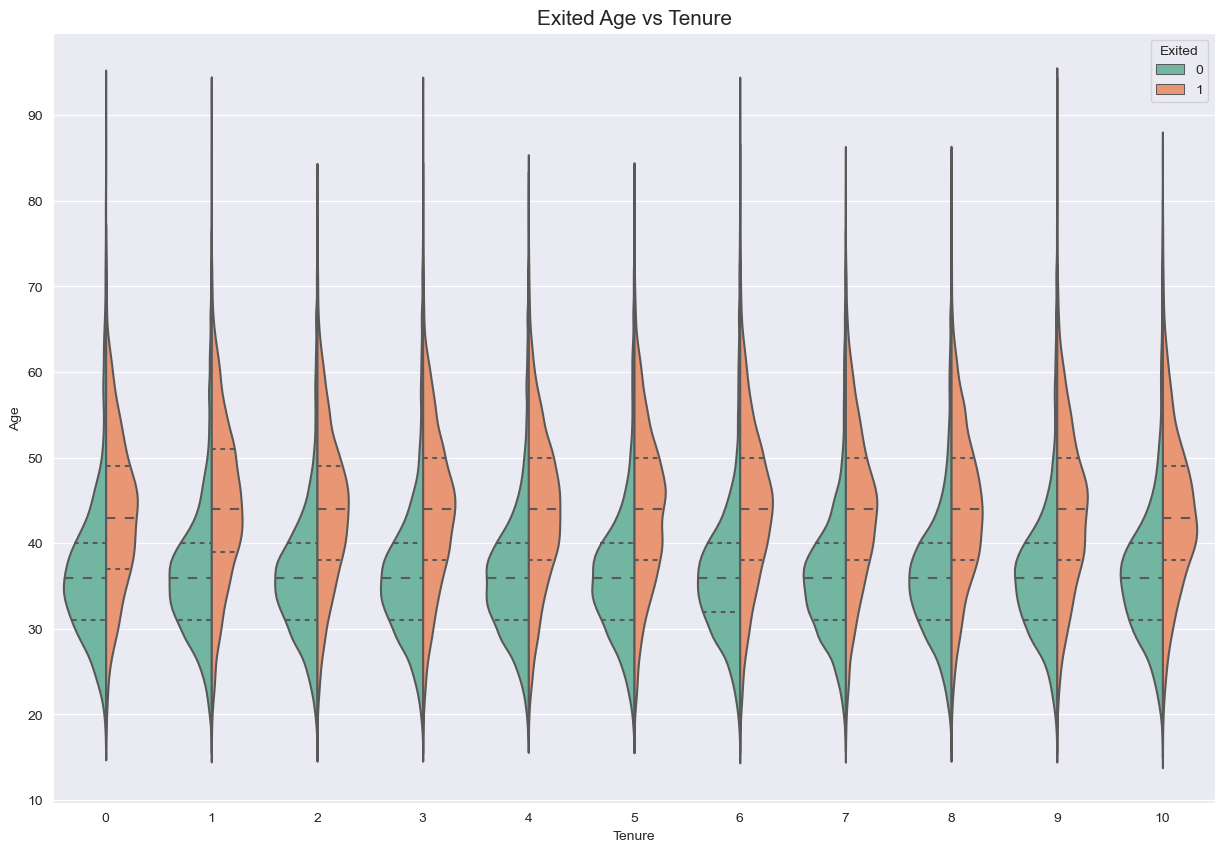

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="Tenure", y="Age", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited Age vs Tenure", fontsize=15)
_ = ax.set_ylabel("Age")
_ = ax.set_xlabel("Tenure")


no significant difference between tenure groups and the relative ages when people exit.

# Balance
To start with, let's cut right to a density plot and see if the Balance feature shows any clear separation between those who exited, and those who didn't. Given the high correlation between Balance and Exited, we expect to see some separation.

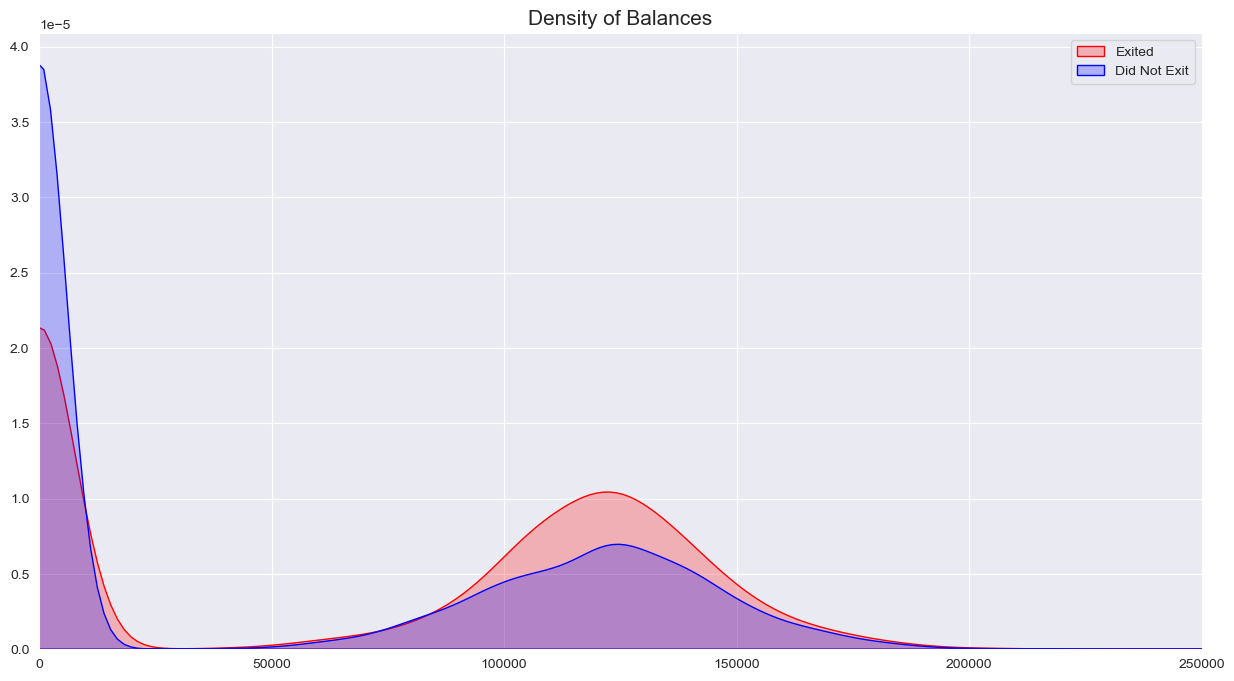

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["Exited"] == 1)]["Balance"], shade=True, color="r", ax=ax, label="Exited")
_ = sns.kdeplot(train[(train["Exited"] == 0)]["Balance"], shade=True, color="b", ax=ax, label="Did Not Exit")
_ = ax.set_title("Density of Balances".format(feature), fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
_ = ax.set_xlim(0, 250000)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:2], labels=labels[0:2], title="")

 it appears that having a $0 balance would be a mitigating factor in regards to whether a patron exits. This does raise an interesting point: why be a patron when you have no balance? Perhaps balances vs number of products will tell us.

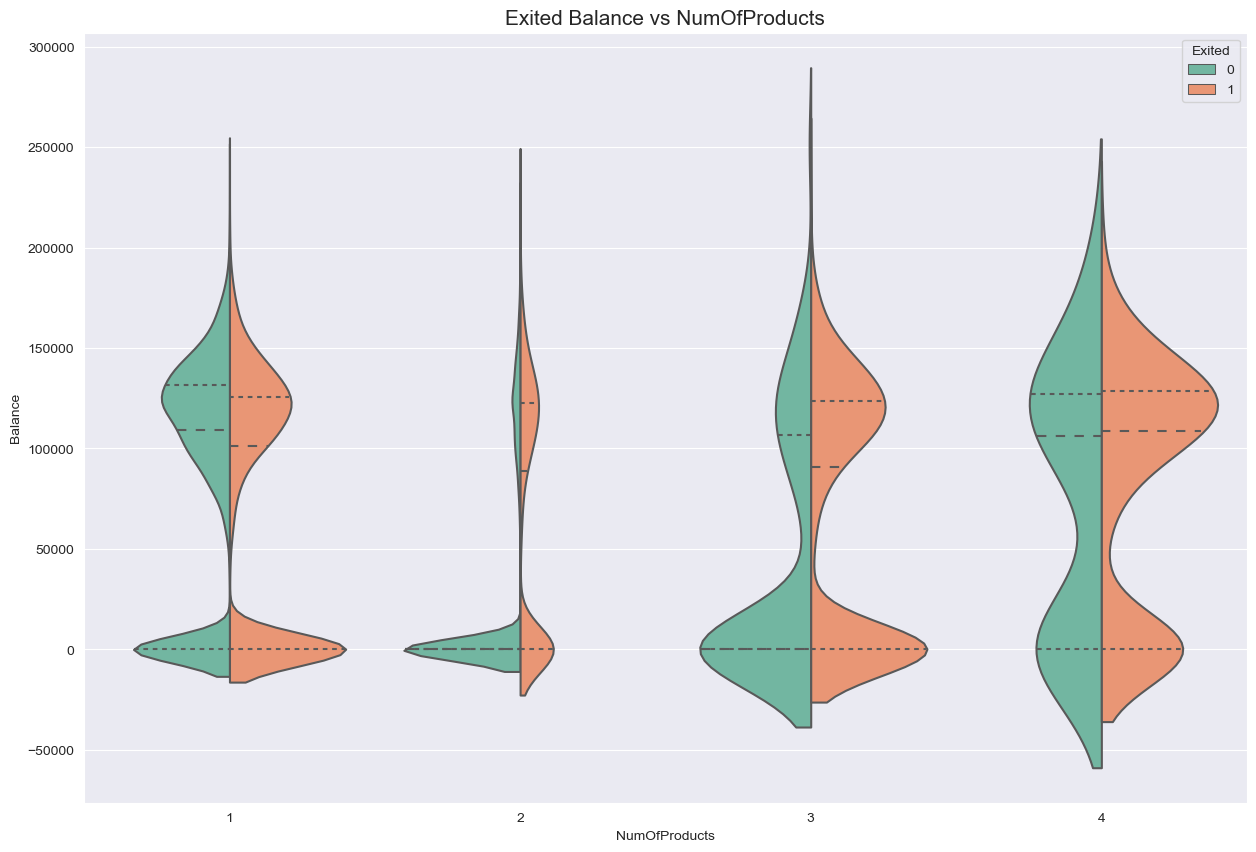

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="NumOfProducts", y="Balance", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited Balance vs NumOfProducts", fontsize=15)
_ = ax.set_ylabel("Balance")
_ = ax.set_xlabel("NumOfProducts")

This is starting to look more interesting. While having 1 or 4 products doesn't help us separate out those that exit from those that don't, the interesting cases occur when there are 2 or 3 products. To summarize:

If the patron has 2 products and $0 balance, they are far less likely to exit.
If the patron has 3 products and a $0 balance, they are far less likely to exit.
If the patron has 3 products and a balance, the user is far more likely to exit.
We can use this information to our advantage as more refined mitigating or risk factors.

# Key Observations about Balance
If the patron has 2 products and $0 balance, they are far less likely to exit.
If the patron has 3 products and a $0 balance, they are far less likely to exit.
If the patron has 3 products and a balance, the user is far more likely to exit.

# NumOfProducts
The number of products a patron has may ultimately be useful in determining whether a patron exits. The initial suspicion is that the more products a patron has, the more likely it would be for them to stick with the bank rather than trying to create products at other banks to cover what they would otherwise lose. Let's take a look at densities to see if there is more information to be learned.

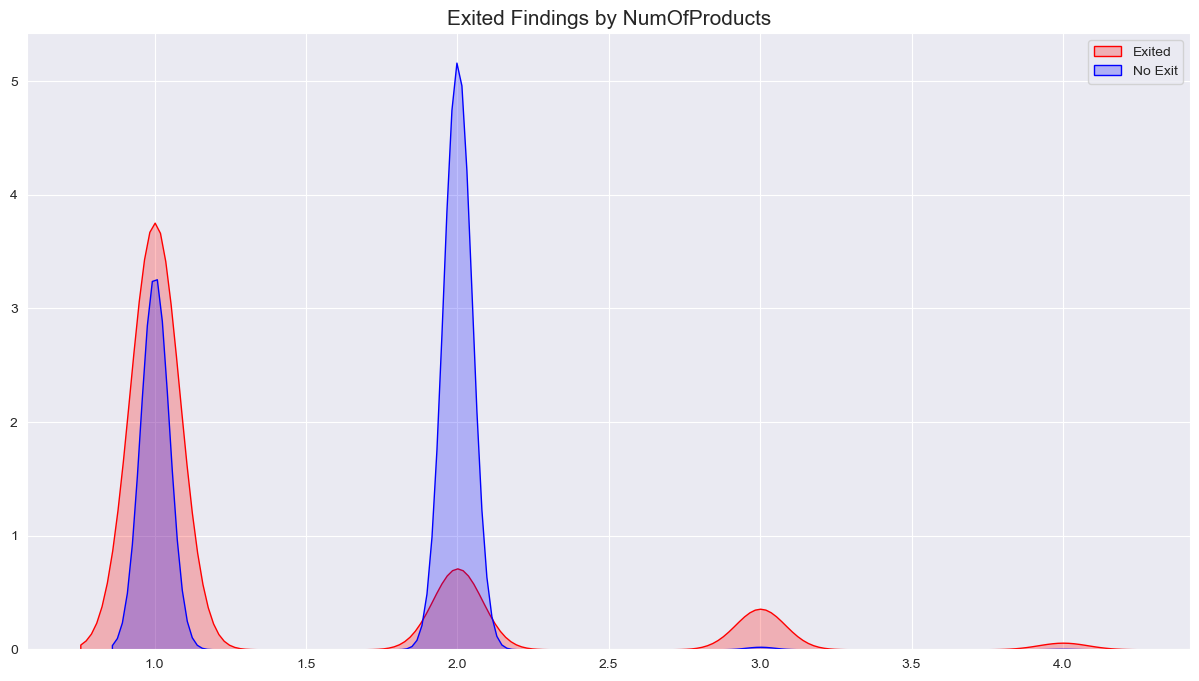

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["Exited"] == 1)]["NumOfProducts"], shade=True, color="r", ax=ax, label="Exited")
_ = sns.kdeplot(train[(train["Exited"] == 0)]["NumOfProducts"], shade=True, color="b", ax=ax, label="No Exit")
_ = ax.set_title("Exited Findings by NumOfProducts".format(feature), fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:2], labels=labels[0:2], title="")

 First, if a patron has 1 product, they are no more or less likely to exit the bank. However, if a user has 2 products, they are far more likely to stay. In contrast, if the user has 3 or 4 products, they are far more likely to exit. Again, we can use these particular findings in our risk features or as mitigating features.

Let's take a look to see if any of the demographic information impacts likelihood to leave based on number of products. First, let's examine age.

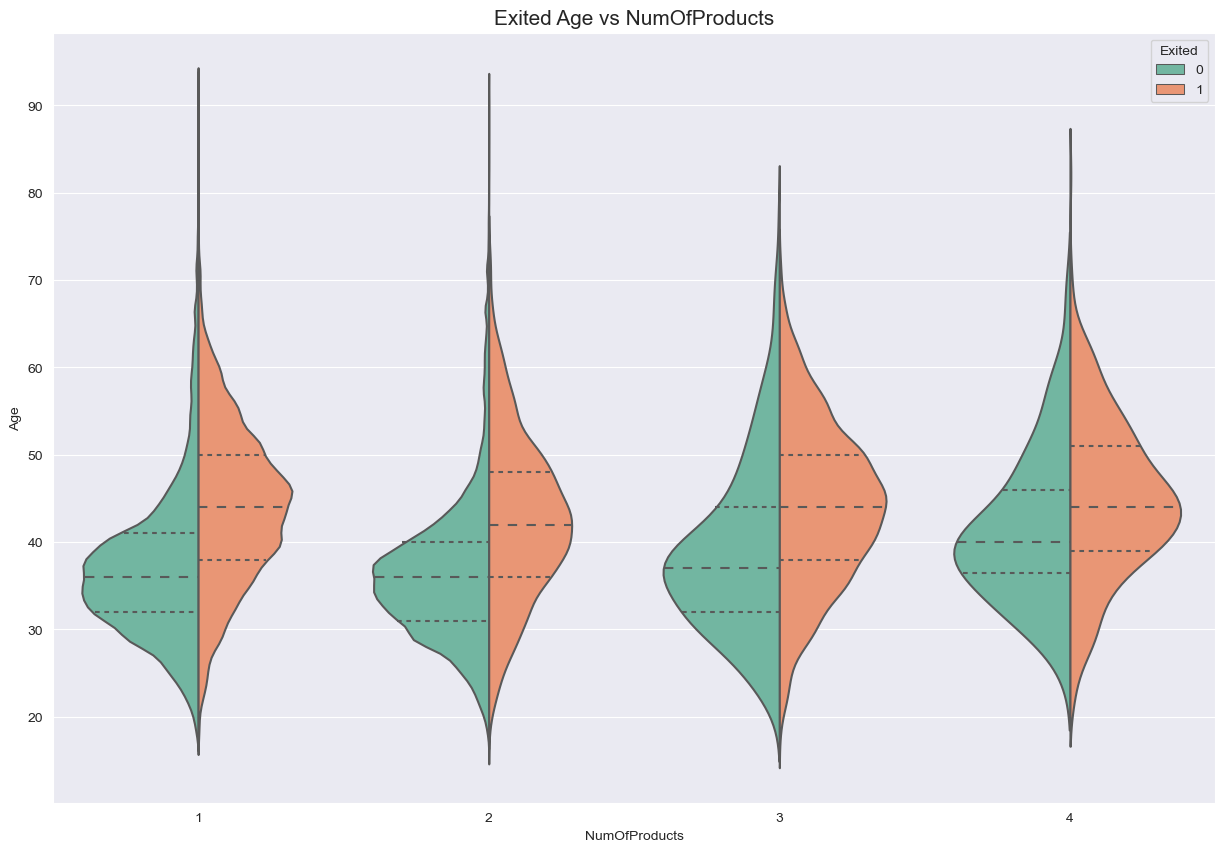

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="NumOfProducts", y="Age", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited Age vs NumOfProducts", fontsize=15)
_ = ax.set_ylabel("Age")
_ = ax.set_xlabel("NumOfProducts")

Older patrons (qualitatively speaking, around the age of 43), are more likely to exit than younger ones (around the age of 36). We can see this based on the mean long dashed markings in the above plot.
This pattern is repeated across all numbers of products - if we look at mean and quartile dashes, those that stay with the bank always skew towards the younger patrons.
Given this observation, it likely isn't going to be too useful to mix age with number of products to work out new features - age will always be the better indicator.
Let's take a look at how this works with geography.

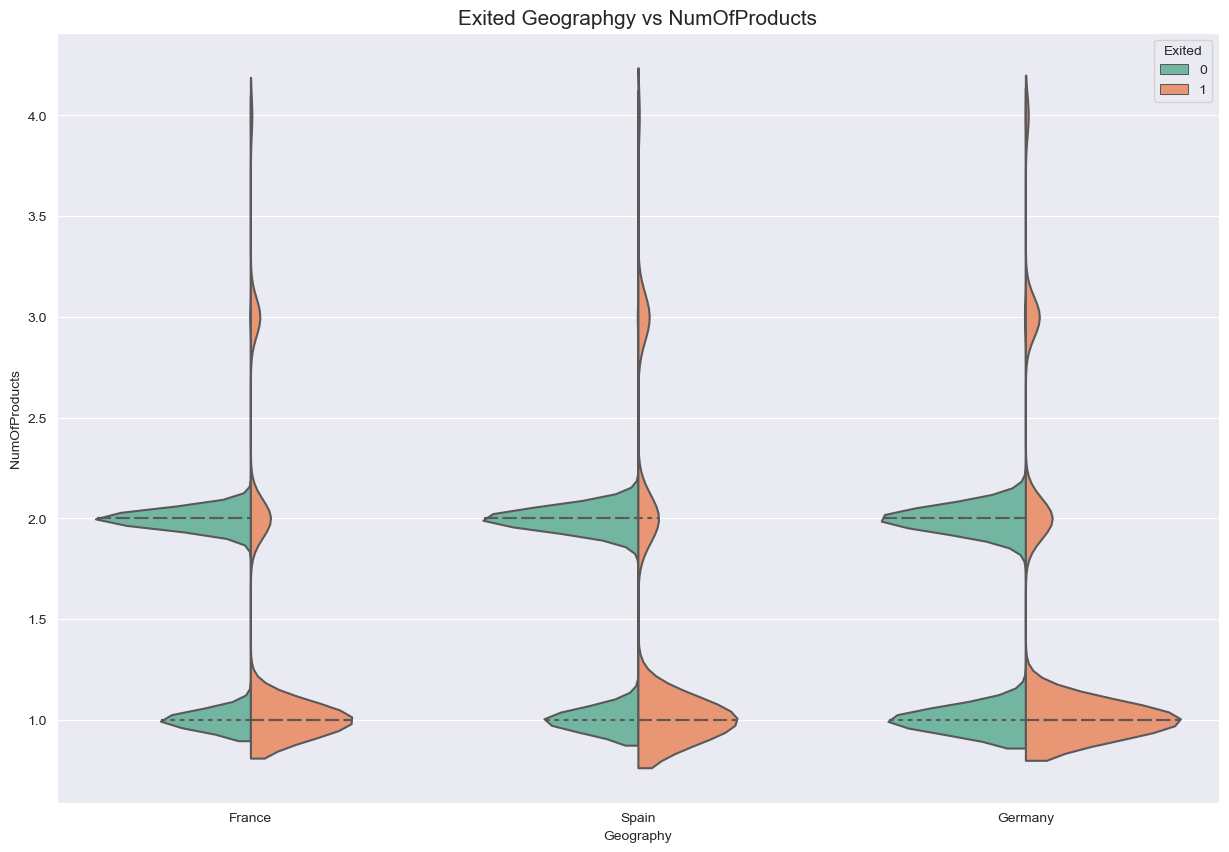

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="Geography", y="NumOfProducts", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited Geographgy vs NumOfProducts", fontsize=15)
_ = ax.set_ylabel("NumOfProducts")
_ = ax.set_xlabel("Geography")

the number of products by geography isn't providing new insights. What we see here are the same trends that we saw before. That is, a greater number of patrons from Germany exit, that patrons are more likely to stay if they have 2 products, and patrons with 3 or more products are more likely to leave.

# Key Observations about NumOfProducts
If a patron has 1 product, they are no more or less likely to exit the bank.
If a patron has 2 products, they are more likely to remain with the bank.
If a patron has 3 products or more, they are more likely to exit the bank.

# HasCrCard

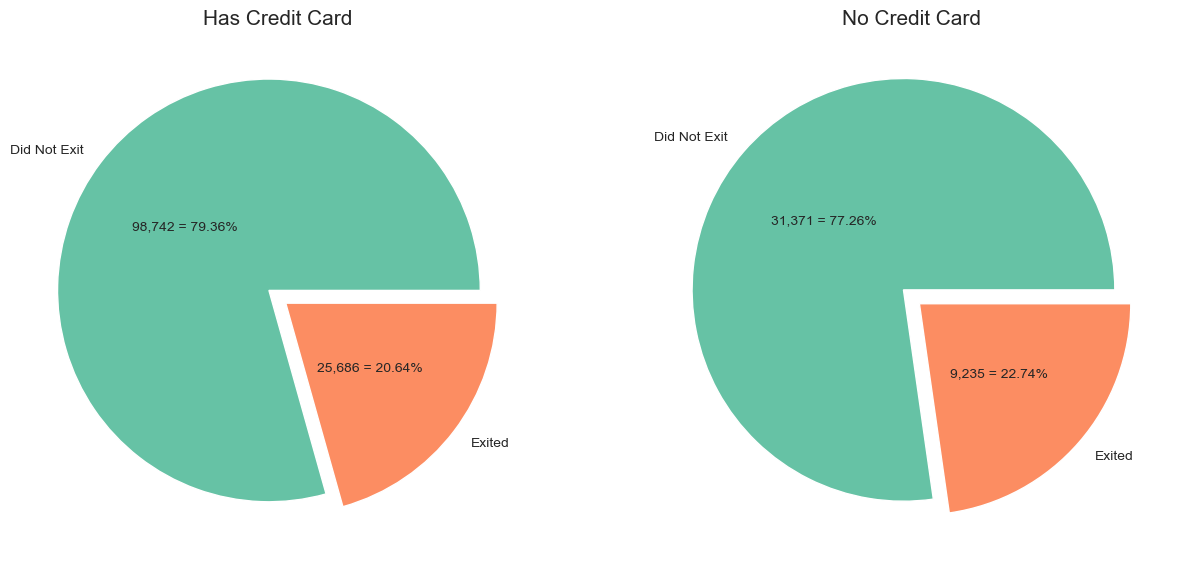

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

has_crcard_types = [place for place in train['HasCrCard'].unique()]
axs = axs.flatten()

for ag, has_crcard in enumerate(has_crcard_types):
    data = [
        train[(train["Exited"] == 0) & (train["HasCrCard"] == has_crcard)]["id"].count(),
        train[(train["Exited"] == 1) & (train["HasCrCard"] == has_crcard)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=["Did Not Exit", "Exited"],
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{'Has Credit Card' if has_crcard == 1 else 'No Credit Card'}", fontsize=15)

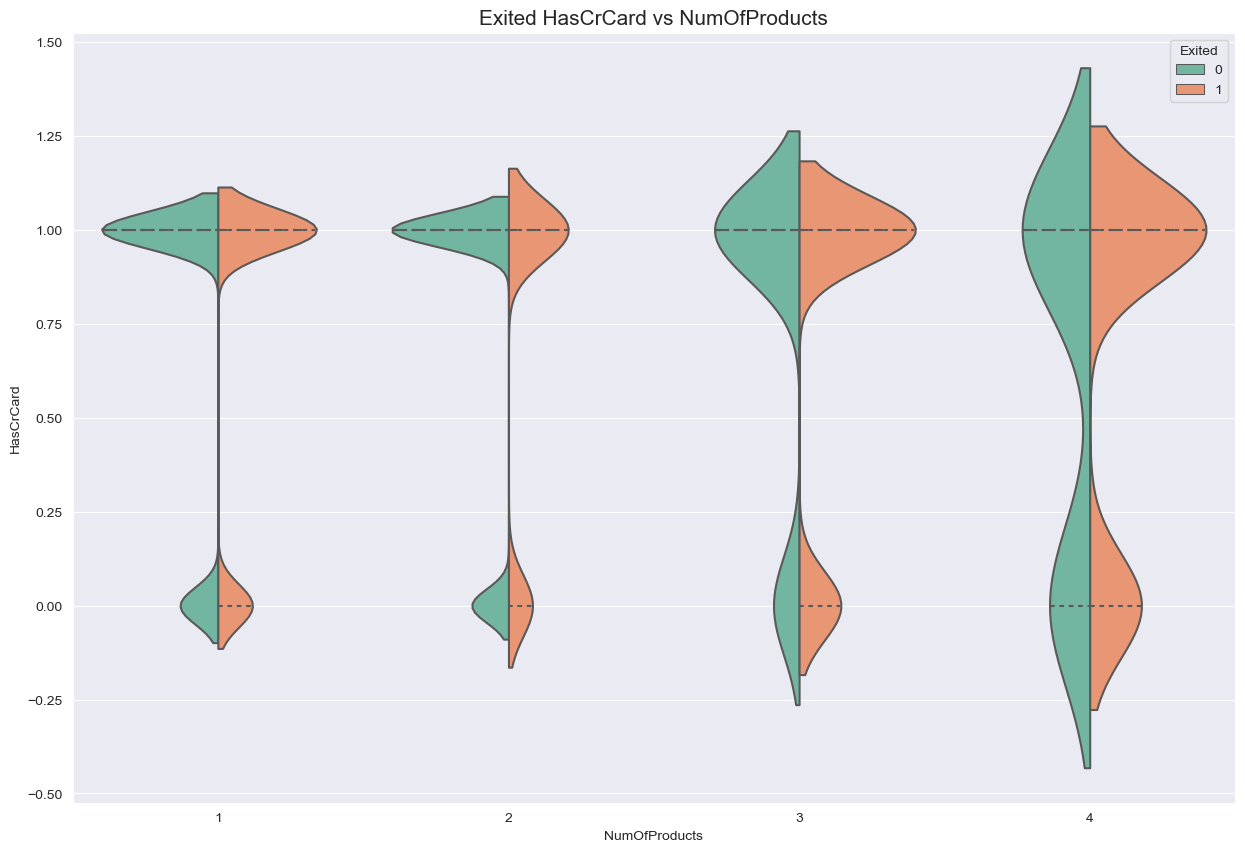

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="NumOfProducts", y="HasCrCard", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited HasCrCard vs NumOfProducts", fontsize=15)
_ = ax.set_ylabel("HasCrCard")
_ = ax.set_xlabel("NumOfProducts")

#  IsActiveMember

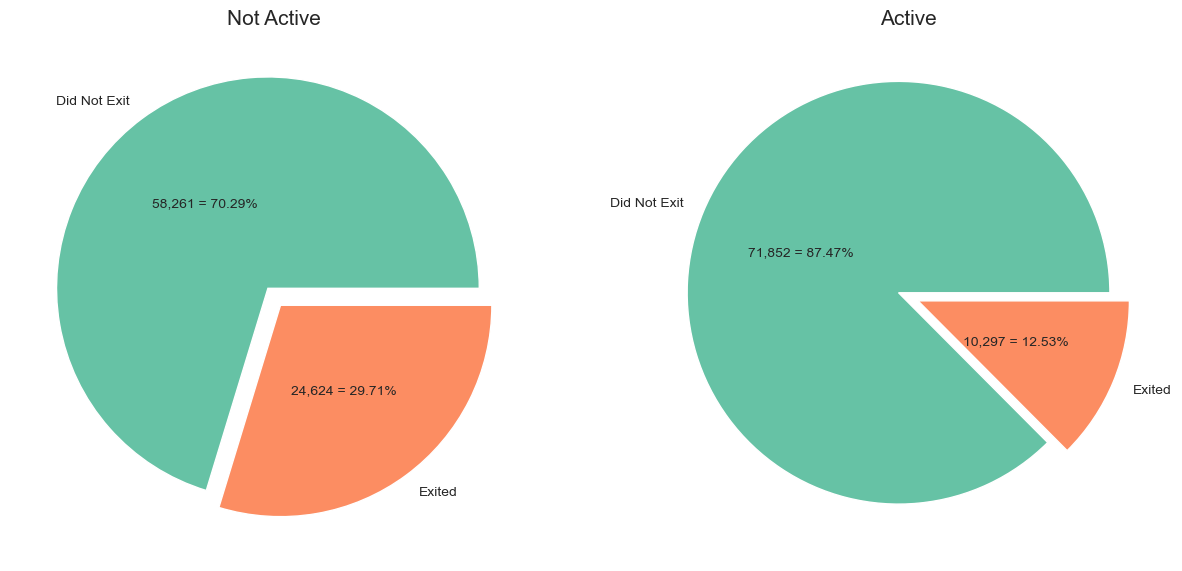

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

is_active_status_types = [place for place in train['IsActiveMember'].unique()]
axs = axs.flatten()

for ag, is_active in enumerate(is_active_status_types):
    data = [
        train[(train["Exited"] == 0) & (train["IsActiveMember"] == is_active)]["id"].count(),
        train[(train["Exited"] == 1) & (train["IsActiveMember"] == is_active)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=["Did Not Exit", "Exited"],
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2, 
        pctdistance=0.5, 
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{'Active' if is_active == 1 else 'Not Active'}", fontsize=15)

# EstimatedSalary

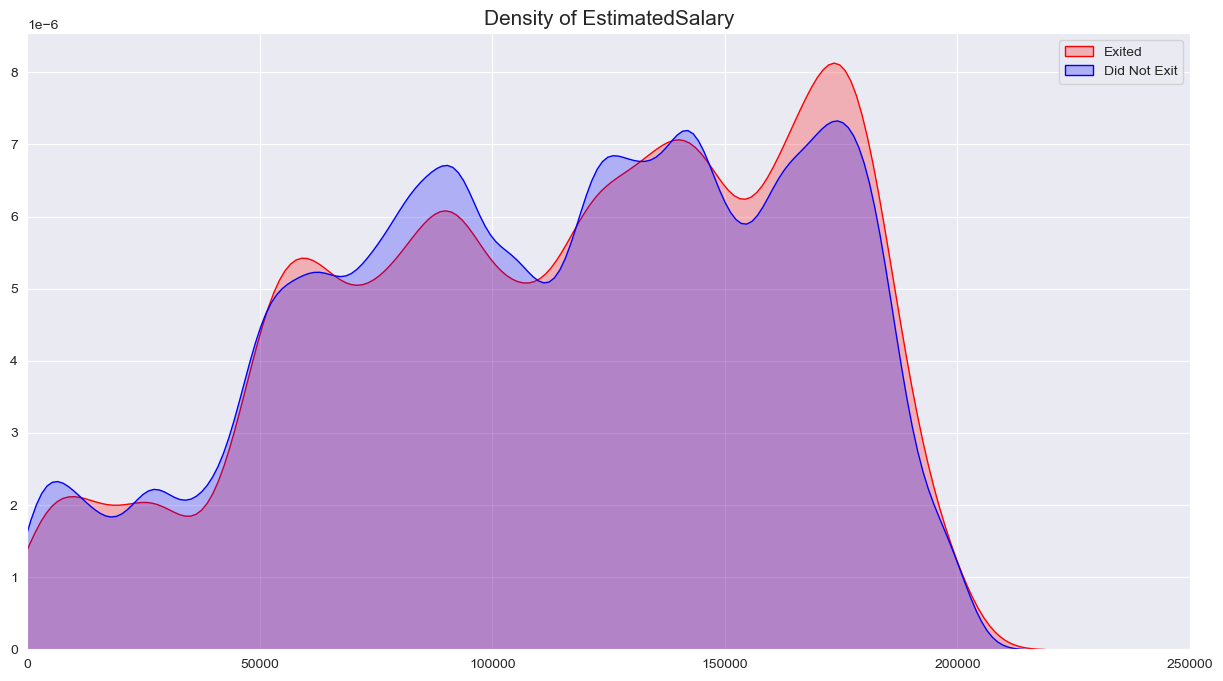

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["Exited"] == 1)]["EstimatedSalary"], shade=True, color="r", ax=ax, label="Exited")
_ = sns.kdeplot(train[(train["Exited"] == 0)]["EstimatedSalary"], shade=True, color="b", ax=ax, label="Did Not Exit")
_ = ax.set_title("Density of EstimatedSalary".format(feature), fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
_ = ax.set_xlim(0, 250000)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:2], labels=labels[0:2], title="")

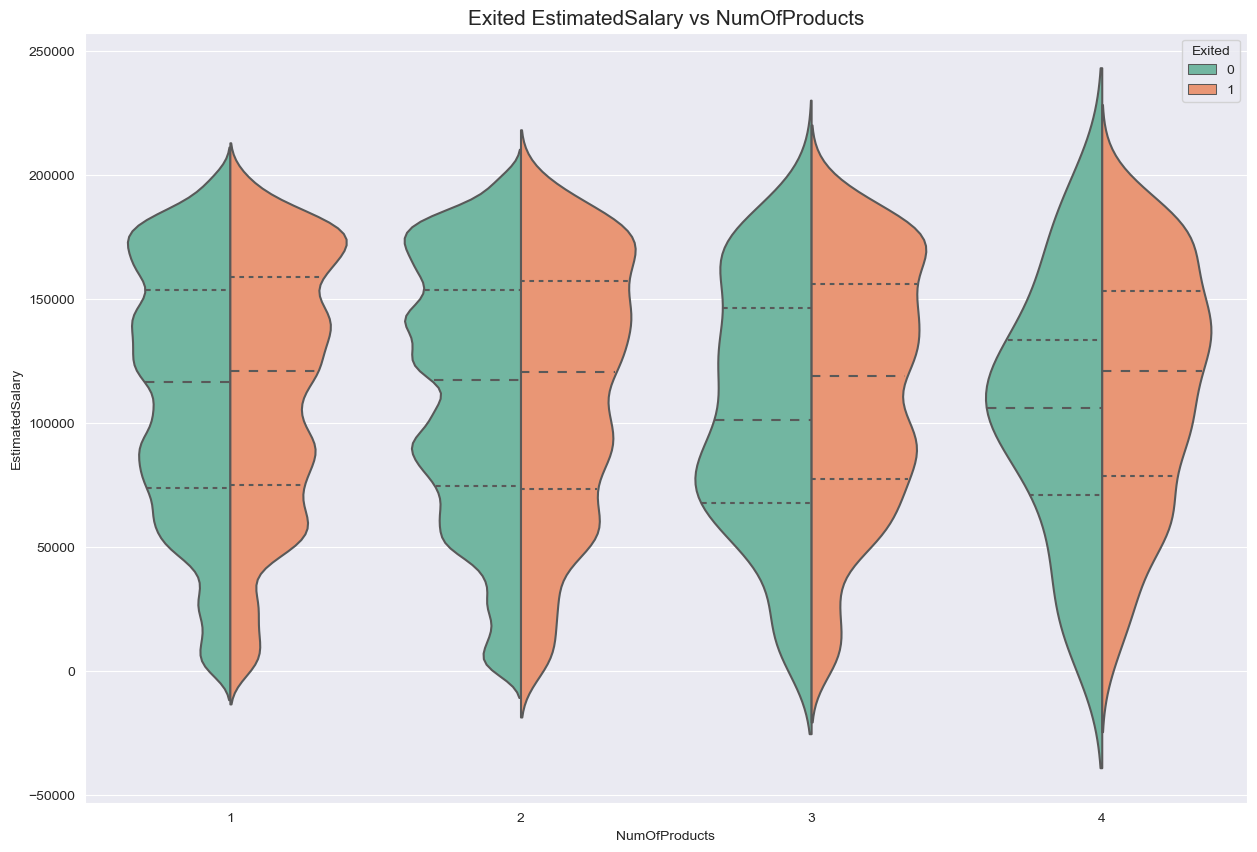

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="NumOfProducts", y="EstimatedSalary", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited EstimatedSalary vs NumOfProducts", fontsize=15)
_ = ax.set_ylabel("EstimatedSalary")
_ = ax.set_xlabel("NumOfProducts")

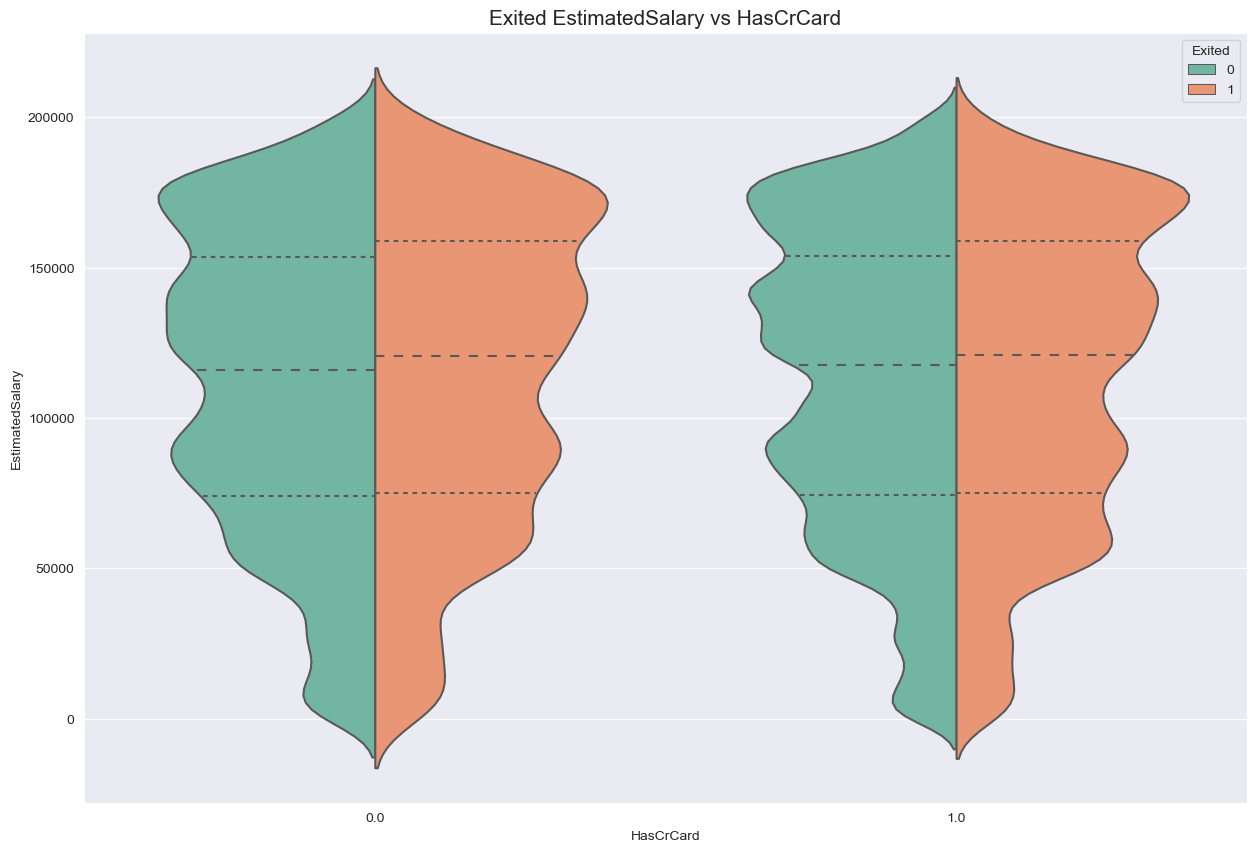

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = sns.violinplot(data=train, x="HasCrCard", y="EstimatedSalary", hue="Exited", split=True, inner="quart")
_ = ax.set_title("Exited EstimatedSalary vs HasCrCard", fontsize=15)
_ = ax.set_ylabel("EstimatedSalary")
_ = ax.set_xlabel("HasCrCard")


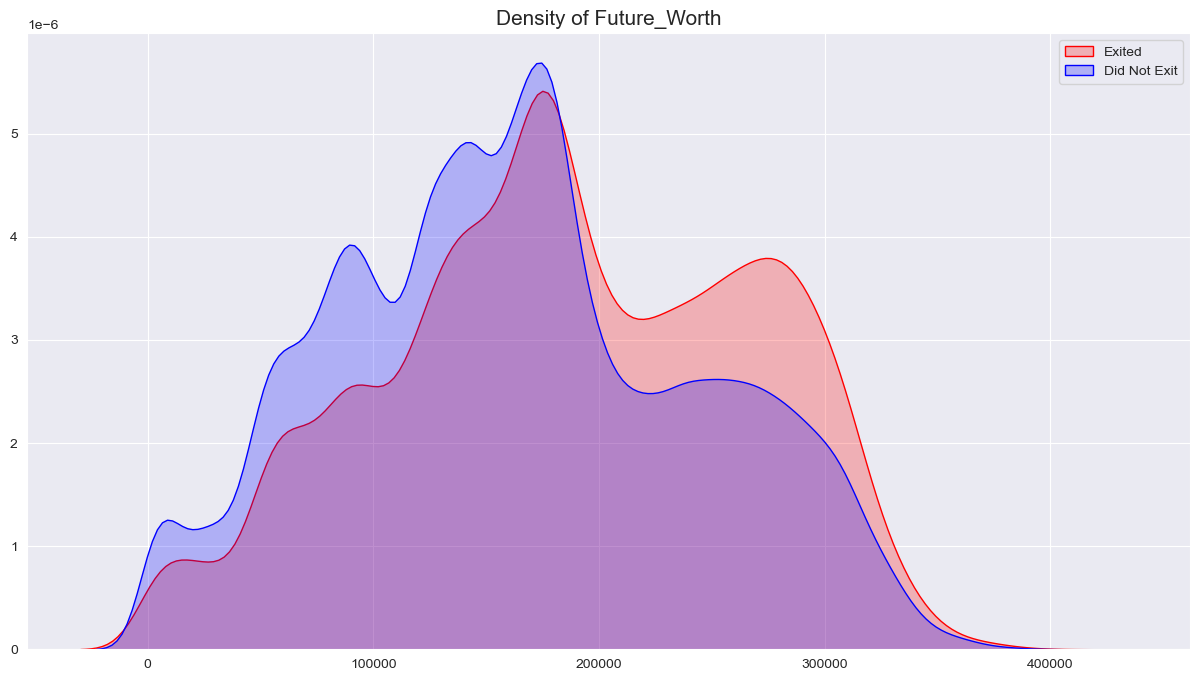

In [45]:
train["Future_Worth"] = train["EstimatedSalary"] + train["Balance"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.set_style('darkgrid')

_ = sns.kdeplot(train[(train["Exited"] == 1)]["Future_Worth"], shade=True, color="r", ax=ax, label="Exited")
_ = sns.kdeplot(train[(train["Exited"] == 0)]["Future_Worth"], shade=True, color="b", ax=ax, label="Did Not Exit")
_ = ax.set_title("Density of Future_Worth".format(feature), fontsize=15)
_ = ax.set_ylabel("")
_ = ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[0:2], labels=labels[0:2], title="")

# Model Comparison
Let's take a look at a few basic models, and see how well they perform with different types of features.

# Vanilla LightGBM
Based on the mix of categorical data, LightGBM is a good model to start with, since we can easily tell it what columns are categorical. We'll label encode the categorical features Surname, Geography and Gender.# 

-------> Fold 1 <--------
: AUC ROC = 0.89122
-------> Fold 2 <--------
: AUC ROC = 0.89115
-------> Fold 3 <--------
: AUC ROC = 0.89391
-------> Fold 4 <--------
: AUC ROC = 0.88976
-------> Fold 5 <--------
: AUC ROC = 0.89015
--> Overall results for out of fold predictions
: AUC ROC = 0.89121


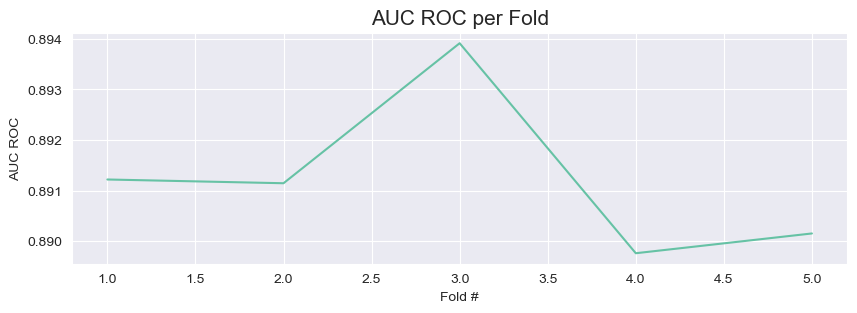

In [46]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_baseline = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_baseline:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

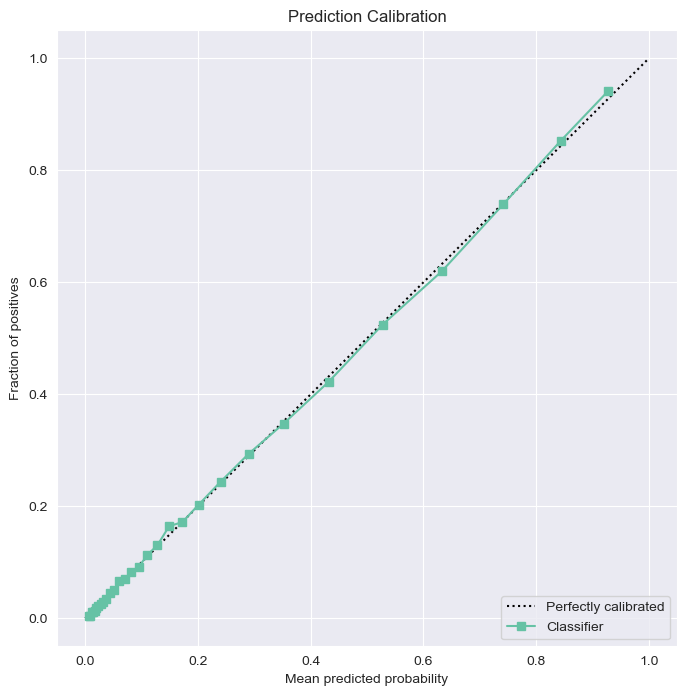

In [47]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

With very little tuning, the classifier does very well, scoring an AUC ROC of 0.89121. The calibration of our predictions looks good too, with predictions fairly spread out along the probability spectrum, although there is some clumping toward the negative class.

# LightGBM Categorical
LightGBM has built-in support for dealing with categorical features, but has to be told which columns are to be interpreted as categorical. Features must be integer encoded. There are smoothing options to deal with categorical features with high cardinality, but we will ignore those for now and use default settings.

-------> Fold 1 <--------
: AUC ROC = 0.89091
-------> Fold 2 <--------
: AUC ROC = 0.89119
-------> Fold 3 <--------
: AUC ROC = 0.89282
-------> Fold 4 <--------
: AUC ROC = 0.88941
-------> Fold 5 <--------
: AUC ROC = 0.88928
--> Overall results for out of fold predictions
: AUC ROC = 0.89065


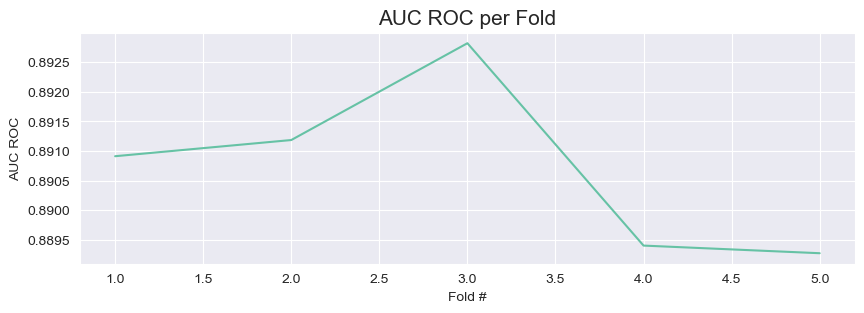

In [48]:
features = [
    'Surname', 'Geography', 'Gender', 'CreditScore', 
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
        categorical_features = [0, 1, 2],
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_category = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_category:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

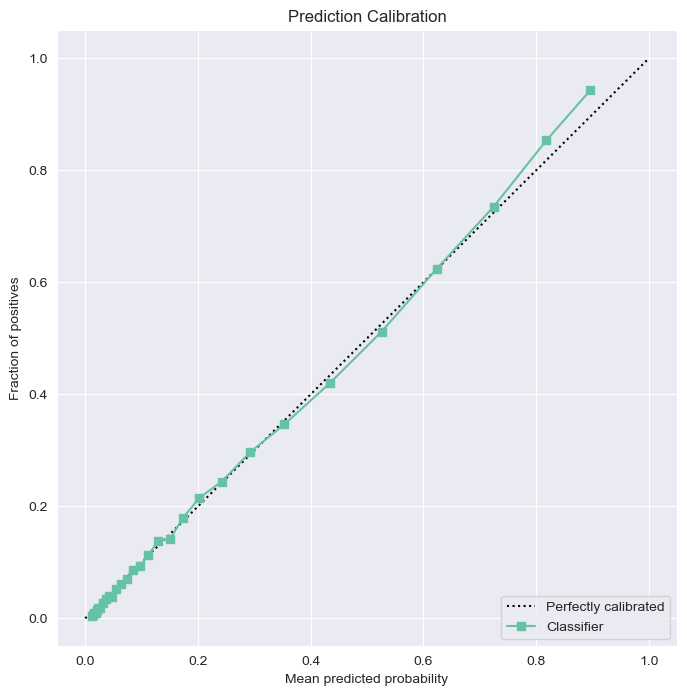

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

we achieve a slightly less performant result, probably due to the high cardinality of the Surname category.

# Feature: First Letter Surname Group
As discussed at the start of our EDA, using just the first letter of the surname may provide additional information to a classifier. Let's try that as a feature.

-------> Fold 1 <--------
: AUC ROC = 0.89164
-------> Fold 2 <--------
: AUC ROC = 0.89159
-------> Fold 3 <--------
: AUC ROC = 0.89382
-------> Fold 4 <--------
: AUC ROC = 0.88981
-------> Fold 5 <--------
: AUC ROC = 0.89042
--> Overall results for out of fold predictions
: AUC ROC = 0.89142


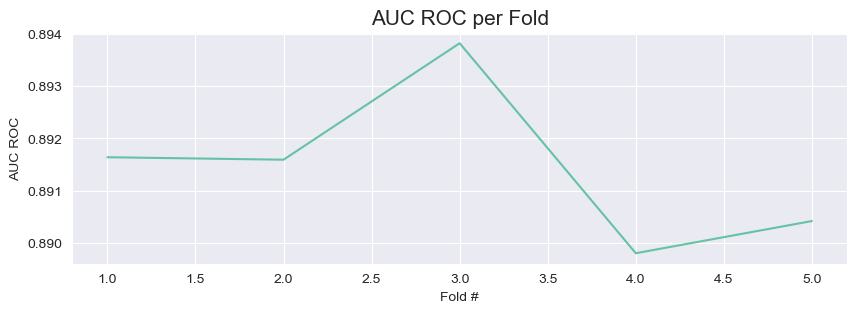

In [50]:
features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()
train_copy["Surname_First_Letter"] = train_copy["Surname"].apply(lambda x: x[0])
features.append("Surname_First_Letter")

for feature in ["Surname", "Geography", "Gender", "Surname_First_Letter"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_first_letter_surname = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_first_letter_surname:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

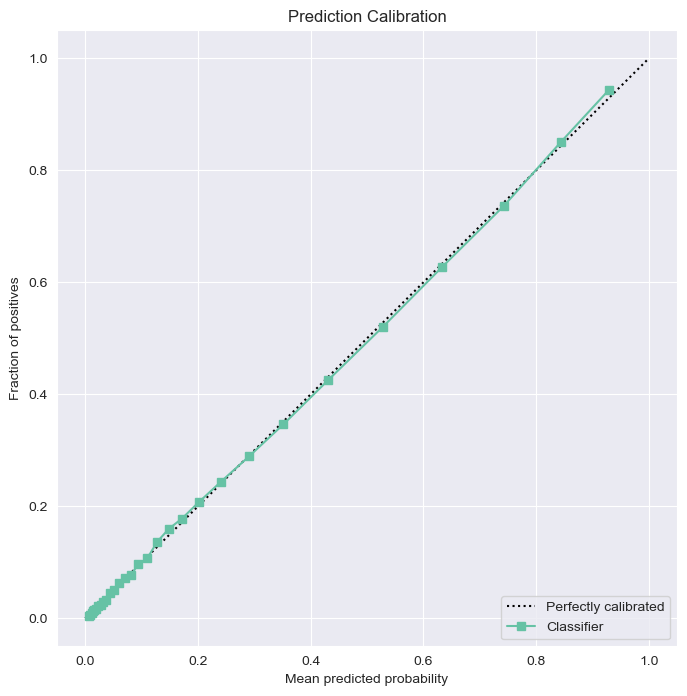

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

# Feature: Age ** NumOfProducts
As discussed in our EDA, our age amplified by the number of products the patron has may provide additional lift. We should test this out as a feature.

-------> Fold 1 <--------
: AUC ROC = 0.89119
-------> Fold 2 <--------
: AUC ROC = 0.89097
-------> Fold 3 <--------
: AUC ROC = 0.89342
-------> Fold 4 <--------
: AUC ROC = 0.88939
-------> Fold 5 <--------
: AUC ROC = 0.89025
--> Overall results for out of fold predictions
: AUC ROC = 0.89102


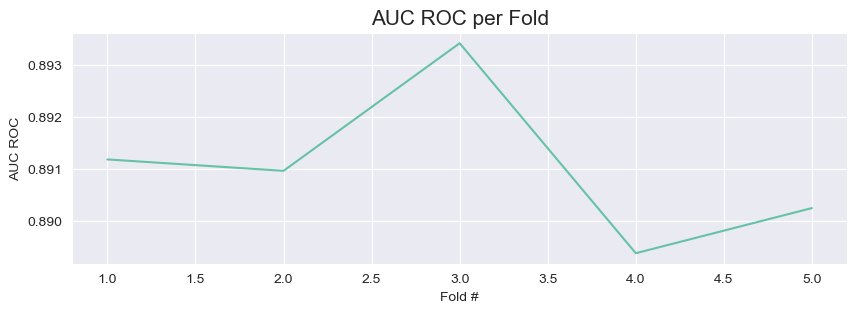

In [52]:
features = [
    'Surname', 'Geography', 'Gender', 'CreditScore', 
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

train_copy["Age_NumOfProducts"] = train_copy["Age"] - train_copy["NumOfProducts"]
features.append("Age_NumOfProducts")

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])
    
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_age_prods = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_age_prods:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

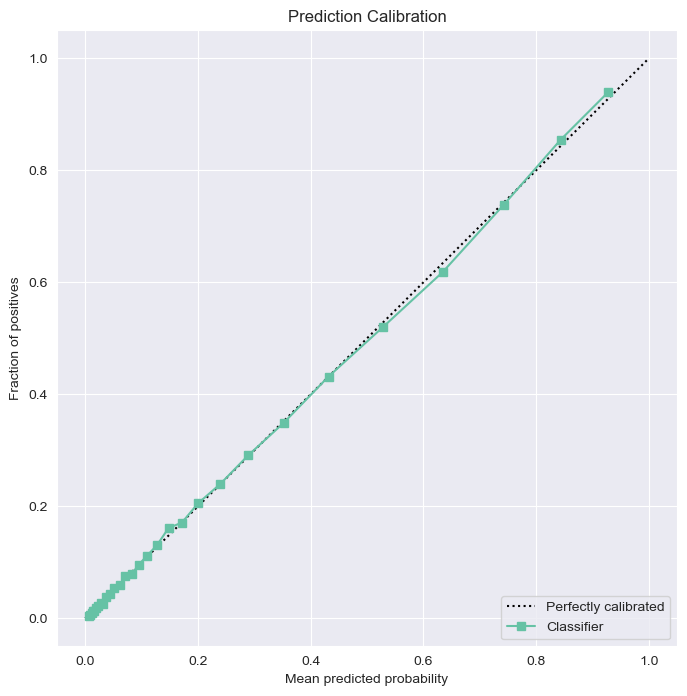

In [53]:
ig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

# Feature: Risk Factor Count
One of the items discussed throughout the EDA was the notion of risk factors. Of these, we came up with the following:

Age > 40
Geography = Germany
NumOfProducts > 2
With that in mind, we can create a risk factor feature that sums up the total number of risk factors.

In [54]:
features = [
    'Surname', 'Geography', 'Gender', 'CreditScore', 
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

train_copy["Risk_Geography"] = train_copy["Geography"].apply(lambda x: 1 if x == "Germany" else 0)
train_copy["Risk_Age"] = train_copy["Age"].apply(lambda x: 1 if x >= 40 else 0)
train_copy["Risk_NumOfProducts"] = train_copy["NumOfProducts"].apply(lambda x: 1 if x > 2 else 0)
train_copy["RiskFactors"] = train_copy["Risk_Geography"] + train_copy["Risk_Age"] + train_copy["Risk_NumOfProducts"]
features.append("RiskFactors")

for feature in ["Surname", "Geography", "Gender"]:
    le = LabelEncoder()
    train_copy[feature] = le.fit_transform(train_copy[feature])
    
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_risk_factors = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_risk_factors:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

-------> Fold 1 <--------
: AUC ROC = 0.89128
-------> Fold 2 <--------
: AUC ROC = 0.89157
-------> Fold 3 <--------
: AUC ROC = 0.89358
-------> Fold 4 <--------
: AUC ROC = 0.89007
-------> Fold 5 <--------
: AUC ROC = 0.88996
--> Overall results for out of fold predictions
: AUC ROC = 0.89126


In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

# Target Encoding
We have a number of encoding options when it comes to encoding our categorical data into a form our classifiers can use. While label encoding is quick, we have other options such as target encoding. With target encoding, we calculate the mean value of the categorical value with respect to the target. In other words, we calculate the prior probability of the categorical value being associated with Exited. This method does have a drawback: it leaks information about our target variable into the features themselves. However, given that it is computationally inexpensive, we should explore it as an option.

In [56]:
from category_encoders.target_encoder import TargetEncoder

features = [
    'Surname', 'Geography', 'Gender', 'CreditScore', 
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

for feature in ["Surname", "Geography", "Gender"]:
    te = TargetEncoder()
    train_copy[feature] = te.fit_transform(train_copy[feature], train_copy["Exited"])
    
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_target_encode = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_target_encode:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

-------> Fold 1 <--------
: AUC ROC = 0.89665
-------> Fold 2 <--------
: AUC ROC = 0.89658
-------> Fold 3 <--------
: AUC ROC = 0.89946
-------> Fold 4 <--------
: AUC ROC = 0.89576
-------> Fold 5 <--------
: AUC ROC = 0.89634
--> Overall results for out of fold predictions
: AUC ROC = 0.89694


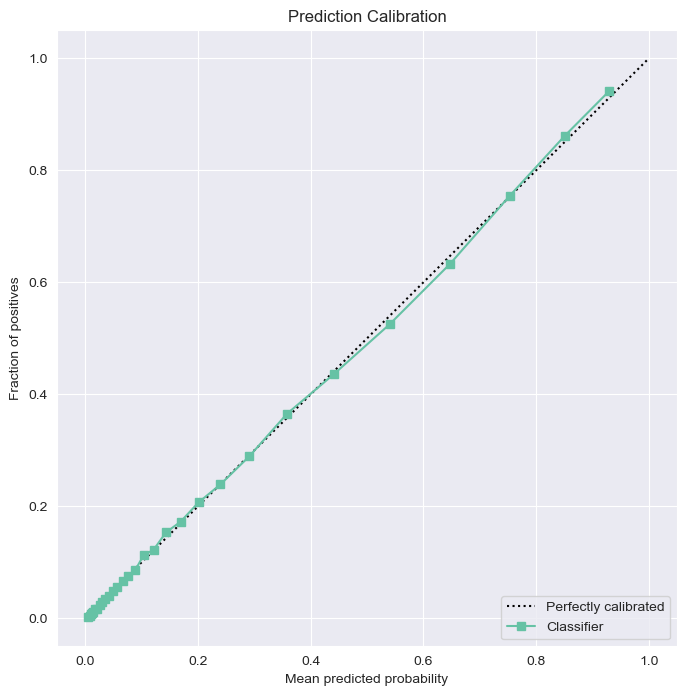

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

# All Beneficial Features
With all our beneficial features turned on, let's run a check to ensure we see lift.

In [58]:
features = [
    'Surname', 'Geography', 'Gender', 'CreditScore', 
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary'
]

train_copy = train.copy()

train_copy["Surname_First_Letter"] = train_copy["Surname"].apply(lambda x: x[0])
features.append("Surname_First_Letter")

for feature in ["Surname", "Geography", "Gender", "Surname_First_Letter"]:
    te = TargetEncoder()
    train_copy[feature] = te.fit_transform(train_copy[feature], train_copy["Exited"])

train_copy["Risk_Geography"] = train_copy["Geography"].apply(lambda x: 1 if x == "Germany" else 0)
train_copy["Risk_Age"] = train_copy["Age"].apply(lambda x: 1 if x >= 40 else 0)
train_copy["Risk_NumOfProducts"] = train_copy["NumOfProducts"].apply(lambda x: 1 if x >= 2 else 0)
train_copy["RiskFactors"] = train_copy["Risk_Geography"] + train_copy["Risk_Age"] + train_copy["Risk_NumOfProducts"]
features.append("RiskFactors")

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_all_good = roc_auc_score(train["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_all_good:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")

-------> Fold 1 <--------
: AUC ROC = 0.89740
-------> Fold 2 <--------
: AUC ROC = 0.89726
-------> Fold 3 <--------
: AUC ROC = 0.89987
-------> Fold 4 <--------
: AUC ROC = 0.89648
-------> Fold 5 <--------
: AUC ROC = 0.89670
--> Overall results for out of fold predictions
: AUC ROC = 0.89753


In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

CalibrationDisplay.from_predictions(train_copy["Exited"], train_oof_preds, n_bins=30, strategy='quantile', ax=ax)
_ = ax.set_title("Prediction Calibration")

# Model Comparisons
Let's compare how the different approaches perform

In [60]:
bar, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(
    x=["Baseline", "Categorical On", "First Letter Surname", "Age ** Products", "Risk Factors", "Target Encoding", "All Good"],
    y=[
        auc_baseline,
        auc_category,
        auc_first_letter_surname,
        auc_age_prods,
        auc_risk_factors,
        auc_target_encode,
        auc_all_good,
    ]
)
_ = ax.axhline(y=auc_baseline, color='r', linestyle='--')
_ = ax.set_title("AUC ROC (Higher is Better)", fontsize=15)
_ = ax.set_xlabel("")
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_ylim([0.89, 0.90])
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x()+(p.get_width()/2),
        y=height,
        s="{:.5f}".format(height),
        ha="center"
    )

# Conclusions

1. The dataset is highly skewed to the negative class.
2. With a large number of samples to learn from, our results may be more stable between local CV, public LB, and private LB.
3. No null values appear in the training or testing datasets.
4. Duplicate columns exist in the dataset, and identical entries have different mappings to Exited.
5. Adversarial validation suggests that the training dataset and the testing dataset are very similar.
5. Adversarial validation suggests there are some easy-to-spot differences between the original dataset and the competition dataset.
     .Caution should be used when mixing data.
     .The Surname categorical column appears to be a           distinguishing factor between datasets.
6. P-value testing suggests there are no features that are likely candidates for removal.
7. For the Surname feature:
   Different types of categorical encoding may make a        difference to our classifier.
   Using only the first letter in the surname as a          feature may provide lift.
8. For the Geography feature:
   People leaving occurs more in Germany than other          geographic locations - this may be useful to generate    a risk factor feature.
9. For the Gender feature:
   Males are far less likely to exit the bank.
   This holds true in both Spain and France.
   Males in Germany are much more likely to exit when       compared to other geographies.
   The Gender feature in Spain and France may be useful      to generate a mitigating factors feature.
10. For the Age feature:
    Age is a strong indicator for our target.
    We may be able to create an additional risk factor       based on age, as ages over 40 are more likely to         exit.
    Age combined with number of products may provide lift      as an additional feature.